## Using Torch 
#### As i am training my model in my Mac book (AIR) ... AIR .!! With over 150 combination to run and also stochastically, machines starts to heat up really quickly, to avoid that I have used torch so that i can use GPU to train the model

In [3]:
from itertools import combinations, product
import sys
import os
import joblib

## for visualization
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

##sklearn
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

##For data manipulation
import torch
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
## to get name of the class while looping through many combination
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [15]:
data = make_regression(n_samples=500, n_features=8, random_state=42, noise=0.3)
X, y = data[0], data[1]

In [16]:
X[:, 0] = np.sin(X[:, 0])  # Sine wave transformation
X[:, 1] = np.log1p(np.abs(X[:, 1]))  # Log transformation (log1p avoids log(0) issue)
X[:, 2] = X[:, 2] ** 2  # Squared transformation
X[:, 3] = np.exp(X[:, 3] / 10) 

In [255]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
np.random.normal()

In [206]:
green_shades = [
    "#0B3D02",  # Very Dark Green
    "#0D5F00",  # Dark Emerald Green
    "#145A32",  # Deep Jungle Green
    "#166D25",  # Rich Green
    "#1B8A3B",  # Medium Dark Green
    "#1D8348",  # Forest Green
    "#229954",  # Medium Green
    "#27AE60",  # Emerald Green
    "#2ECC71",  # Soft Green
    "#34D058",  # Vibrant Green
    "#39D27F",  # Bright Lime Green
    "#3AE87D",  # Fresh Green
    "#42F59E",  # Mint Green
    "#58D68D",  # Light Green
    "#5BE395",  # Light Emerald
    "#70EF9C",  # Pastel Green
    "#82E0AA",  # Soft Pastel Green
    "#A9DFBF",  # Pale Mint Green
    "#C8F7C5",  # Very Light Green
    "#D5F5E3"   # Almost White Green
]

## Creating a Custom Class for regression 

In [351]:
class TorchRegression:
    
    def __init__(self, regularization:float = None, lr:float=0.01, method:str = 'mini_batch', weight_init:str = 'zeros', batch_size:int = 64, n_epochs:int =150, momentum:float=None, poly_degree:int=None, cv:int=5, use_gpu:bool=False, log_transform: bool = False, use_mlflow:bool=False):
        self.lr = lr ##learning rate
        self.method = method ##for type of descent
        self.weight_init = weight_init ## for weight initialization like normal, xavier and so on
        self.batch_size = batch_size ## incase of mini_batch 
        self.n_epochs = n_epochs
        self.regularization = regularization ## we have two type ridge and lasso 
        self.momentum = momentum ##for faster convergence to global minima and also useful for avoiding local minima
        self.use_mlflow = use_mlflow
        self.poly_degree = poly_degree 
        self.cv = cv ##kfold split
        self.weight_decay = 1e-5
        self.device = torch.device("mps" if use_gpu and torch.backends.mps.is_available() else "cpu")
        self.log_transform = log_transform
        self.prev_step =  0
        
        valid_method = ['mini_batch', 'stochastic', 'batch']
        valid_weight = ['normal', 'xavier', 'zeros']
        
        if self.method not in valid_method:
            raise ValueError(f'method must be in {valid_method}')
        if self.weight_init not in valid_weight:
            raise ValueError(f'weight_init must be in {valid_weight}')
        
    def fit(self, X, y):
    
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.astype(np.float32).values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.astype(np.float32).values
    
        # Convert to PyTorch Tensors
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device)
        
        # Apply Log Transform to y (if enabled)
        if self.log_transform:
            y = torch.log1p(y)
    
        # Apply Polynomial Features (if enabled)
        if self.poly_degree is not None:
            X = self._polynomial_features(X)
            
        intercept = torch.ones((X.shape[0], 1), dtype=torch.float32, device=self.device)
        X = torch.cat((intercept, X), dim=1) 
            
        patience = 4
        epoch_without_improvement = 0
        self.kfold_train_accuracy_list = []
        self.kfold_train_loss_list = []
    
        cv = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        y_np = y.cpu().numpy().flatten() 
        print(y_np.shape)
        print(X.shape)
        
        for fold, (train_idx, val_idx) in enumerate(cv.split(X.cpu().numpy())):
            
            # Initialize Weights
            self.W = self.weight_initializer(X)
            
            x_train_cross = X[train_idx]
            y_train_cross = torch.tensor(y_np[train_idx], dtype=torch.float32, device=self.device) 
            x_val_cross = X[val_idx]
            y_val_cross = torch.tensor(y_np[val_idx], dtype=torch.float32, device=self.device)
    
            self.old_loss = torch.tensor(float('inf'), device=self.device)  
            
            if self.use_mlflow:
                run = mlflow.start_run(run_name=f"Fold-{fold}", nested=True)
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__}
                mlflow.log_params(params=params)
    
            for epoch in range(self.n_epochs):
                perm_idx = torch.randperm(x_train_cross.shape[0])
                x_train_cross = x_train_cross[perm_idx]
                y_train_cross = y_train_cross[perm_idx]
    
                if self.method == 'mini_batch':
                    for i in range(0, len(x_train_cross), self.batch_size):
                        batch_X = x_train_cross[i:i+self.batch_size]
                        batch_y = y_train_cross[i:i+self.batch_size]
                        train_loss, train_accuracy = self._train(batch_X, batch_y)
                        
                elif self.method == 'stochastic':
                    for i in range(x_train_cross.shape[0]):
                        batch_X = x_train_cross[i].unsqueeze(0)
                        batch_y = y_train_cross[i].unsqueeze(0)
                        train_loss, train_accuracy = self._train(batch_X, batch_y)

                else:
                    train_loss, train_accuracy = self._train(x_train_cross, y_train_cross)
    
                self.kfold_train_accuracy_list.append(train_accuracy)
                self.kfold_train_loss_list.append(train_loss)
    
                train_loss_tensor = torch.tensor(self.kfold_train_loss_list, dtype=torch.float32, device=self.device).clone().detach()
                train_accuracy_tensor = torch.tensor(self.kfold_train_accuracy_list, dtype=torch.float32, device=self.device).clone().detach()
    
                y_hat_val = self._predict(x_val_cross, is_train=True)
                val_loss, val_accuracy = self.mse(y_val_cross, y_hat_val), self.r2_score(y_val_cross, y_hat_val)
                
                if self.use_mlflow:
                    mlflow.log_metric(key="val_loss", value=val_loss.item(), step=epoch)
                    mlflow.log_metric(key="val_r2", value=val_accuracy.item(), step=epoch)
                
                if torch.allclose(self.old_loss, val_loss.clone().detach(), atol=1e-3):
                    epoch_without_improvement += 1 
                    if epoch_without_improvement >= patience: 
                        print('early stopping')
                        break
                else: 
                    epoch_without_improvement = 0
    
                self.old_loss = val_loss
    
            print(f"{fold} --> train_loss: {torch.mean(train_loss_tensor):.3f} | train_accuracy: {torch.mean(train_accuracy_tensor) :.4f} | val_loss: {val_loss:.4f} | val_accuracy: {val_accuracy:.4f}")
            
            if self.use_mlflow:
                mlflow.end_run()
                                    
    def _predict(self, X, is_train=False):
      
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.astype(np.float32).values
        elif isinstance(X, np.ndarray): 
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        
        ##applying polynomial for test data     
        if not is_train and self.poly_degree is not None:
            X = self._polynomial_features(X)
        
        # Add intercept term (bias) to X if missing
        if X.shape[1] == self.W.shape[0] - 1:  # Check if bias is missing
            intercept = torch.ones((X.shape[0], 1), dtype=torch.float32, device=self.device)
            X = torch.cat((intercept, X), dim=1)
    
        if X.shape[1] != self.W.shape[0]:  
            print(X.shape, self.W.shape)
            raise ValueError(f"Mismatch: X has {X.shape[1]} features, but W has {self.W.shape[0]}.")

        return X @ self.W
    
    def _train(self, X, y):
        y_hat = self._predict(X ,is_train=True)
        m = X.shape[0]
        
        grad = (1/m) * X.T @ (y_hat-y) 
        
        grad += self.weight_decay * self.W

        if self.momentum is not None:
            if not hasattr(self, 'velocity'):
                self.velocity = torch.zeros_like(self.W)
            self.velocity = self.momentum * self.velocity - self.lr * grad
            self.W = self.W + self.velocity
        else:
            self.W = self.W - self.lr * grad
       
        #torch.nn.utils.clip_grad_norm_(self.W, max_norm=5.0)  # Clip gradients
        # Check for NaN or Inf values
        if torch.isnan(self.W).any() or torch.isinf(self.W).any():
            print("Warning: NaN or Inf detected in weights!")
            self.W = torch.where(torch.isnan(self.W) | torch.isinf(self.W), torch.randn_like(self.W) * 0.01, self.W)
    
        return self.mse(y, y_hat), self.r2_score(y, y_hat)
    
    def mse(self, ytrue, ypred): ## for mean square error
        return (torch.sum((ypred - ytrue) ** 2)) / ytrue.shape[0]
    
    def r2_score(self, ytrue, ypred):
        
        rss = torch.sum((ytrue - ypred) ** 2)
        tss = torch.sum((ytrue - torch.mean(ytrue)) ** 2)
        return 1 - (rss / tss)

    def weight_initializer(self, X):
        if self.weight_init == 'zeros':
            return torch.zeros(X.shape[1], device=self.device, dtype=torch.float32)
        elif self.weight_init == 'xavier':
            limit = (1 / torch.sqrt(torch.tensor(X.shape[1], dtype=torch.float32, device=self.device)))
            return torch.empty(X.shape[1], device=self.device, dtype=torch.float32).uniform_(-limit, limit) 
        else:  # Default: Normal Distribution
            return torch.randn(X.shape[1], dtype=torch.float32, device=self.device) * 0.01
        
    def _polynomial_features(self, X): ## raising the features to higher power 
        
        X = X.to(self.device)
        if self.poly_degree is None:
            return X 
       
        n_samples, n_features = X.shape
        poly_features = [X]
          
        for degree in range(2, self.poly_degree + 1):
            poly_features.append(X**degree)
        
        # Interactions with terms (X1 * X2, X1*X3 and so on)
        if self.poly_degree == 2:
            interaction_terms = [torch.prod( X[:, torch.tensor(combo, device=self.device)], axis=1) for combo in combinations(range(n_features), 2)  ]
            return torch.column_stack(poly_features+interaction_terms)
        
        return torch.cat(poly_features, dim=1)
    
    def _coef(self):
        return self.W[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.W[0]
    
    def plot_feature_importance(self, feature_names=None):
        
        if isinstance(self.W, torch.Tensor):
            feature_importance = self.W.detach().cpu().numpy()
        else: feature_importance = self.W
        
        num_feature = len(feature_importance)
        if feature_names is None:
            feature_names = [f'Feature {i+1}' for i in range(num_feature)]
        
        expanded_feature_names = self.get_expanded_feature_names(feature_names)

    
        feature_weight_dict = {name.split("^")[0]: 0 for name in expanded_feature_names}

        for name, weight in zip(expanded_feature_names, feature_importance):
            base_feature = name.split("^")[0]  # Extract base feature name
            feature_weight_dict[base_feature] += abs(weight)  # Sum absolute importance

    
        sorted_features = sorted(feature_weight_dict.items(), key=lambda x: x[1], reverse=True)
        coefs_df = pd.DataFrame(sorted_features, columns=["Feature", "Importance"])
    
        max_importance = coefs_df["Importance"].max()
        min_importance = coefs_df["Importance"].min()
        
        if max_importance > min_importance:  
            normalized_importance = (coefs_df["Importance"] - min_importance) / (max_importance - min_importance)
            color_indices = (normalized_importance * (len(green_shades) - 1)).astype(int)
        else:
            color_indices = [len(green_shades) // 2] * len(coefs_df)  # Default middle shade if importance is constant

        colors = [green_shades[idx] for idx in color_indices]
        
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x=coefs_df["Importance"], y=coefs_df["Feature"], palette=colors,) 
    
        max_importance = max(np.abs(coefs_df["Importance"]))
        ##adding data label with positioning
        for index, value in enumerate(coefs_df["Importance"]):
            label = f"{value:.4f}"
            if abs(value) < 0.05 * max_importance:  # If bar is **too short**
                ax.text(value + (0.05 * max_importance), index, label, 
                    va='center', ha='left', fontsize=12, color='black', fontweight='bold')  
            else:
                ax.text(value * 0.95, index, label, 
                    va='center', ha='right' if value > 0 else 'left', fontsize=12, color='white', fontweight='bold')  

        # Add labels and title
        plt.xlabel('Feature Importance', fontsize=14)
        plt.ylabel('Features', fontsize=14)
        plt.title('Feature Importance Plot', fontsize=16)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
    
        # Show the plot
        plt.show()
    
    def get_expanded_feature_names(self, feature_names):
        
        if self.poly_degree is None or self.poly_degree == 1:
            return feature_names  # No transformation, return as is
    
        expanded_feature_names = []
        
        # Generate polynomial feature names (x, x^2, x^3, ...)
        for degree in range(1, self.poly_degree + 1):
            expanded_feature_names.extend([f"{col}^{degree}" for col in feature_names])
    
        return expanded_feature_names

In [332]:
class l1_Penalty:
    
    def __init__(self, l):
        self.l = l 
    
    def __call__(self, *args, **kwargs):
        return self.l * torch.sum(torch.abs(args[0]))
    
    def derivation(self, W, *args):
        return self.l * torch.sign(W)
    
class l2_Penalty:
    
    def __init__(self, l):
        self.l = l
    
    def __call__(self, *args):
        return self.l * torch.sum(torch.square(args[0]))
    
    def derivation(self, *args):
        return self.l * 2 * args[0]
    
class LassoRegression(TorchRegression):
    
    def __init__(self,l=0.1, **kwargs):
        super().__init__(regularization=l1_Penalty(l=l), **kwargs)
        
class RidgeRegression(TorchRegression):
    
    def __init__(self,l=0.1, **kwargs):
        super().__init__(regularization=l2_Penalty(l=l), **kwargs)


## Building data set

In [333]:

df = pd.read_csv('Out_287.csv')
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

In [334]:
Xdata, ydata = df.loc[:, df.columns != 'selling_price'], df['selling_price']

In [335]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=42)
Xtrain[['fuel', 'seller_type', 'transmission']] = Xtrain[['fuel', 'seller_type', 'transmission']].astype(str)
Xtest[['fuel', 'seller_type', 'transmission']] = Xtest[['fuel', 'seller_type', 'transmission']].astype(str)

In [336]:
num_col = df.select_dtypes(include='number').columns.tolist()

In [ ]:
for col in num_col:
    sns.displot(x=col, data=df, kde=True, color='green')
    plt.show()
## Key take away from understanding this numerical feature distribution plot 
# as Regression model is based on euclidean distance for calculating the gradient, outliers, skewness greatly alters model predicting capabilities 
## Better to understand the data and transform it according to its distribution 
##year --> left skewness --> power to 2 transform
## kms_driven --> right skew --> log transform 
##max_power --> slight right skew --> log 

In [337]:
##Target encoding 
brand_means = Xtrain.join(ytrain).groupby('brand')['selling_price'].mean()

Xtrain['brand_encoded'] = Xtrain['brand'].map(brand_means)
Xtest['brand_encoded'] = Xtest['brand'].map(brand_means)

Xtest['brand_encoded'] = Xtest['brand_encoded'].fillna(brand_means.mean())

##Drop the brand column
Xtrain = Xtrain.drop(columns=['brand'])
Xtest = Xtest.drop(columns=['brand'])


## Defining columns for transformation
final_cat_col = ['fuel', 'seller_type','transmission']
final_num_col = ['km_driven','mileage','engine','max_power', 'year','seats','owner', 'brand_encoded']

log_transformer = FunctionTransformer(lambda x: np.log1p(np.abs(x)) if isinstance(x, (np.ndarray, pd.DataFrame)) else x)

# Define Preprocessor Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), final_cat_col),  # OneHot Encoding for categorical
    ('log_transform', Pipeline(steps=[
        ('log', FunctionTransformer(np.vectorize(np.log1p))),  # Ensures proper transformation
        ('scaler', MinMaxScaler())  
    ]), ['km_driven', 'max_power', 'engine']),  # Apply only to numerical columns
    ('std_scaler', StandardScaler(), ['year', 'mileage', 'seats', 'owner', 'brand_encoded'])  
], remainder='drop')



In [338]:
Xtrain_transformed

array([[ 0.    ,  1.    ,  0.    , ...,  1.5474, -0.6824,  0.2682],
       [ 1.    ,  1.    ,  0.    , ..., -0.4557,  0.6783, -0.371 ],
       [ 0.    ,  1.    ,  0.    , ...,  0.5459, -0.6824,  0.2682],
       ...,
       [ 0.    ,  1.    ,  0.    , ..., -0.4557, -0.6824, -0.371 ],
       [ 1.    ,  1.    ,  0.    , ..., -0.4557, -0.6824, -0.371 ],
       [ 0.    ,  1.    ,  0.    , ...,  3.5505, -0.6824,  0.2682]],
      shape=(5330, 12))

## Preprocessing 

In [339]:

Xtrain_transformed = preprocessor.fit_transform(Xtrain) ##training data being transformed

In [340]:
xtest_transformed = preprocessor.transform(Xtest) ##test data as well

In [341]:
# One-Hot Encoded Feature Names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(final_cat_col)

# Log Transformed & Scaled Feature Names
log_scaled_feature_names = ['km_driven', 'max_power', 'engine']

# Standard Scaled Features
scaled_feature_names = ['year', 'mileage', 'seats', 'owner', 'brand_encoded']

# Combine All Feature Names
transformed_feature_names = np.concatenate([ohe_feature_names, log_scaled_feature_names, scaled_feature_names])

print("Transformed Feature Names:", transformed_feature_names)


Transformed Feature Names: ['fuel_Petrol' 'seller_type_Individual' 'seller_type_Trustmark Dealer'
 'transmission_Manual' 'km_driven' 'max_power' 'engine' 'year' 'mileage'
 'seats' 'owner' 'brand_encoded']


## CV search using Mlflow to register 

In [1041]:
os.environ["LOGNAME"] = "st124783_darth_binit"

In [1040]:
mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("A2_st124783_Chaky_car")

2025/02/02 18:09:31 INFO mlflow.tracking.fluent: Experiment with name 'A2_st124783_Chaky_car' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1738494571351, experiment_id='1', last_update_time=1738494571351, lifecycle_stage='active', name='A2_st124783_Chaky_car', tags={}>

NameError: name 'Xtrain' is not defined

In [1209]:
regs = ["TorchRegression", "RidgeRegression", "LassoRegression"]
lr = [0.01, 0.001, 0.0001]
weights = ['zeros', 'xavier']
methods = ["normal","stochastic", "mini_batch"]
momentum = [None, 0.8]
degrees = [None, 2]  # Polynomial degrees

# Initialize best models for tracking
best_model_r2, best_r2 = None, float('-inf')
best_model_mse, best_mse = None, float('inf')

def run_experiment(reg, method, poly_degree, weight, momentum, lr, use_gpu, cv, log_transform, use_mlflow):
    """Runs an ML experiment, logs results in MLflow, and tracks best models."""
    global best_model_r2, best_r2, best_model_mse, best_mse  # Track best models

    poly_msg = "Polynomial" if poly_degree is not None else "Linear"
    momentum_msg = "Momentum is used" if momentum is not None else "Momentum is not used"

    params = {
        "method": method, "lr": lr, "weight_init": weight, "poly_degree": poly_degree,
        "momentum": momentum, "use_gpu": use_gpu, "cv": cv, "log_transform": log_transform, "use_mlflow": use_mlflow}

    print(f" Running {reg} | {method} | {poly_msg} | {weight} | {momentum_msg} | LR: {lr}")

    # Get Model Class
    type_of_regression = str_to_class(reg)    
    model = type_of_regression(**params)

    with mlflow.start_run(run_name=f"method-{method}-lr-{lr}-reg-{reg}-poly-{poly_msg}-momentum-{momentum_msg}-weight-{weight}", nested=True):

        # Train model
        model.fit(Xtrain_transformed, ytrain)

        # Predictions
        y_pred = model._predict(xtest_transformed)
        
        ytest_tensor = torch.tensor(ytest.values, dtype=torch.float32, device=model.device) 
        # Compute metrics (convert torch tensors to scalars)
        test_loss = model.mse(torch.log1p(ytest_tensor), y_pred).item()  # Convert Tensor → Scalar
        test_r2 = model.r2_score(torch.log1p(ytest_tensor), y_pred).item()  # Convert Tensor → Scalar

        # Log hyperparameters & metrics
        mlflow.log_params(params)  
        mlflow.log_metrics({"test_mse": test_loss, "test_r2": test_r2})

        # Save Model Signature
        signature = mlflow.models.infer_signature(Xtrain_transformed, model._predict(Xtrain_transformed))
        mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

        print(f"✅ Fold: {method} | Model: {reg} | MSE: {test_loss:.4f} | R²: {test_r2:.4f}")

        # Track the Best Model Based on MSE (LOWER IS BETTER)
        if test_loss < best_mse:
            best_mse = test_loss
            best_model_mse = model

        # Track the Best Model Based on R² Score (HIGHER IS BETTER)
        if test_r2 > best_r2:
            best_r2 = test_r2
            best_model_r2 = model

# Iterate over all hyperparameter combinations
combinations_ = product(regs, methods, degrees, weights, momentum, lr)

# Run all experiments
for reg, method, poly_degree, weight, momentum, lr in combinations_:
    run_experiment(reg, method, poly_degree, weight, momentum, lr, cv=5, log_transform=True, use_gpu=False, use_mlflow=True)

#Final Results: Best Models Based on MSE & R² Score
print(f"Best Model by R² Score: {best_model_r2} with R² Score: {best_r2:.4f}")
print(f"Best Model by MSE: {best_model_mse} with MSE: {best_mse:.4f}")

mlflow.end_run()

 Running TorchRegression | normal | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 25.103 | train_accuracy: -44.8813 | val_loss: 4.1249 | val_accuracy: -6.2114
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4b80f73acc2e484ea7c8d5b0e2287d00
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 14.387 | train_accuracy: -25.2231 | val_loss: 3.1305 | val_accuracy: -4.9746
🏃 View run Fold-1 at: http://127.0.0.1:5001/#/experiments/1/runs/95b884b489894708a27a600ed2ab66ce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
2 --> train_loss: 10.686 | train_accuracy: -18.4626 | val_loss: 3.1644 | val_accuracy: -4.7748
🏃 View run Fold-2 at: http://127.0.0.1:5001/#/experiments/1/runs/a288d78522eb42b289a2520259f27ac7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
3 --> train_loss: 8.781 | train_accuracy: -14.9851 | val_loss: 2.9805 | val_accuracy: -4.4058
🏃 View run Fold-3 at: http://12

2025/02/03 01:49:25 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:49:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.594 | train_accuracy: -12.8246 | val_loss: 2.9618 | val_accuracy: -4.2489
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/37cf39d2f89d4817b7faccd712273c3c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 2.8436 | R²: -3.8656
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/151d0a1ca6574132a83e8645837b857d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 116.909 | train_accuracy: -212.6753 | val_loss: 78.5731 | val_accuracy: -136.3663
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/96de4e6ee7fe407fb6d2f930ae5cc81d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 86.311 | train_accuracy: -155.6662 | va

2025/02/03 01:49:33 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.


4 --> train_loss: 44.976 | train_accuracy: -80.5987 | val_loss: 7.9691 | val_accuracy: -13.1230
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2fb346c3b9134a5fb9774bb1226b5b56
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


2025/02/03 01:49:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


✅ Fold: normal | Model: TorchRegression | MSE: 7.6891 | R²: -12.1566
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/04e49dc1b0f44d7fbf38b6dbf964facd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 160.598 | train_accuracy: -292.5249 | val_loss: 154.6803 | val_accuracy: -269.4214
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b5a8c5ec76124445b72fcab4955b182b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 154.644 | train_accuracy: -278.7488 | val_loss: 143.4313 | val_accuracy: -272.7367
🏃 View run Fold-1 at: http://127.0.0.1:5001/#/experiments/1/runs/5553017ab8b340da934a142c8a6967c6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
2 --> train_loss: 149.080 | train_accuracy: -2

2025/02/03 01:49:40 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:49:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 138.654 | train_accuracy: -250.1417 | val_loss: 114.2337 | val_accuracy: -201.4480
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a5bea9aed4cb47f298add688438e4b51
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 113.4844 | R²: -193.1787
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/8169a66877d74c54a7c04aba69d053e4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 84.006 | train_accuracy: -152.5381 | val_loss: 38.1465 | val_accuracy: -65.6901
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/27231ecf4b7c4342baea040d84df2e45
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 52.809 | train_accuracy: -95.0990

2025/02/03 01:49:47 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:49:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 24.515 | train_accuracy: -43.5850 | val_loss: 4.1011 | val_accuracy: -6.2680
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a2e8319e53084ca98221e49fb1d7d7dc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 3.9812 | R²: -5.8121
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/435525408660434fb0e52a8dc95c0e4a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 154.089 | train_accuracy: -280.6279 | val_loss: 142.7771 | val_accuracy: -248.6115
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/16b3f9a712b24b0a9086f28c1a2fb802
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 143.168 | train_accuracy: -258.0951 | val_los

2025/02/03 01:49:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:49:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 116.425 | train_accuracy: -209.8799 | val_loss: 78.6334 | val_accuracy: -138.3563
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f6a5f3c71f0f473f9abf01481f4dc7c9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 77.8547 | R²: -132.2141
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/bcfaa28e93294a51b2a1da6b64db39c0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 165.482 | train_accuracy: -301.4521 | val_loss: 164.3796 | val_accuracy: -286.3783
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/386143b82fbd41f1aab7e7c6c113a563
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 164.184 | train_accuracy: -295.9089

2025/02/03 01:50:00 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 160.545 | train_accuracy: -289.8025 | val_loss: 154.5064 | val_accuracy: -272.8204
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/45b4eb126f4f49f385ea8cf100281972
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 153.8616 | R²: -262.2665
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/b8d71b01899d4cdb840a35094d52e1a1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 24.593 | train_accuracy: -43.9480 | val_loss: 4.5610 | val_accuracy: -6.9738
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/caeb26b42fab43448e72f25f7e22b07c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 14.327 | train_accuracy: -25.1064 |

2025/02/03 01:50:07 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.711 | train_accuracy: -13.0332 | val_loss: 3.2285 | val_accuracy: -4.7216
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/8125b2c2d3ce4a6386eeb923a13b9744
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 3.0712 | R²: -4.2549
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/5a25c93d145b4d1ca4952a5f23e79c8f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 138.493 | train_accuracy: -252.1228 | val_loss: 92.7734 | val_accuracy: -161.1920
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a42a2dbd2cc34dbe81d33dcb49d08399
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 102.295 | train_accuracy: -184.6784 |

2025/02/03 01:50:14 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 53.172 | train_accuracy: -95.4669 | val_loss: 9.5248 | val_accuracy: -15.8800
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a0371fc903844c859cff3d2755cc0292
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 8.9079 | R²: -14.2419
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/c77c907ba5db49b4a2543552f0666138
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 185.707 | train_accuracy: -338.4167 | val_loss: 178.6221 | val_accuracy: -311.2778
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/1c59932adc834c02ace33432b8de3490
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 179.141 | train_accuracy: -323.

2025/02/03 01:50:20 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 160.483 | train_accuracy: -289.6749 | val_loss: 135.5627 | val_accuracy: -239.2478
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/bf89923c1ccf43fd88687f0cc5a89903
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 132.0155 | R²: -224.8864
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/9345ee95f7ba481f97c6715b724c319b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 102.960 | train_accuracy: -187.1803 | val_loss: 46.0010 | val_accuracy: -79.4218
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/f44e856ec27240d695d3fcba8c679b44
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 64.322 | train_accuracy: -116.

2025/02/03 01:50:27 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 29.365 | train_accuracy: -52.4125 | val_loss: 4.2698 | val_accuracy: -6.5671
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3ab377b9f8434ad88c513953e1ac3797
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 4.1221 | R²: -6.0532
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/64ceabaaff9849f1896012011a762e89
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 171.820 | train_accuracy: -313.0356 | val_loss: 157.3085 | val_accuracy: -274.0163
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/26be7057263948dda6da3984fe137085
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 159.468 | train_accuracy: -287.5963 | val_l

2025/02/03 01:50:34 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 129.330 | train_accuracy: -233.2552 | val_loss: 87.7477 | val_accuracy: -154.5089
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/caf6f3e0c5bd4cbca81508d98a347f67
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 87.7279 | R²: -149.1076
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/c382e087cd5d4f6883029c1e8fffd624
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 219.802 | train_accuracy: -400.7321 | val_loss: 219.5546 | val_accuracy: -382.8385
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2d3725e51f53479f9dab5495eaf45089
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 218.278 | train_accuracy: -393.72

2025/02/03 01:50:40 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 213.649 | train_accuracy: -385.9898 | val_loss: 205.7074 | val_accuracy: -363.5602
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/9c5d89dae2a74235b8ee84fcf4bb7036
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 200.6702 | R²: -342.3587
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/25eec13767754157bcab9c87131cd4c8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 11.729 | train_accuracy: -20.4377 | val_loss: 5.1951 | val_accuracy: -8.0824
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6d70710f456a44239f72c9d65304c001
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.976 | train_accuracy: -13.495

2025/02/03 01:50:47 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.837 | train_accuracy: -7.7823 | val_loss: 2.4738 | val_accuracy: -3.3841
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/bcd76a4cd9194431bf17548ebaa85025
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 2.1961 | R²: -2.7577
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/b10518ffc0e34d49a3c86f7cc8cb8ef1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 55.123 | train_accuracy: -99.7486 | val_loss: 17.7057 | val_accuracy: -29.9541
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/400c1b422b3c445ebf4bbc1dc3a182ce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 34.048 | train_accuracy: -60.9768 |

2025/02/03 01:50:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:50:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.841 | train_accuracy: -31.4440 | val_loss: 6.9486 | val_accuracy: -11.3145
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/bce156f0086c49ba8c363d2bdead0720
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 5.8245 | R²: -8.9660
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/aaa0d3f5a7da4d48bae3e27574f2192f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 139.279 | train_accuracy: -253.5597 | val_loss: 116.2590 | val_accuracy: -202.2510
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/96414838275e48b781cf93ba7b5c9d72
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 119.063 | train_accuracy: 

2025/02/03 01:51:01 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 82.542 | train_accuracy: -148.5593 | val_loss: 41.6527 | val_accuracy: -72.8181
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/91743c901127495ba439458f7f632bcb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 39.1979 | R²: -66.0700
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/9871ace0247b449abdef6d2c00d7c0dd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 32.070 | train_accuracy: -57.6152 | val_loss: 9.2359 | val_accuracy: -15.1468
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/33eb888b6a1a48fbae13e6af17452151
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 19.919 | train_accuracy: -35.254

2025/02/03 01:51:08 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 11.182 | train_accuracy: -19.3297 | val_loss: 5.3036 | val_accuracy: -8.3992
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/da7671d8d82b4514a9903866db40850b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 4.7206 | R²: -7.0773
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/054c79423a3048989ebed4178cdedab7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 117.542 | train_accuracy: -213.8312 | val_loss: 83.8238 | val_accuracy: -145.5457
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2edd2888d7dd48268f797ea0bc86b6c4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 91.079 | train_accuracy: -164.2076 | v

2025/02/03 01:51:15 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 54.264 | train_accuracy: -97.3974 | val_loss: 21.1253 | val_accuracy: -36.4389
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/405b99b1fec042ae991f277b49e253a3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 17.7806 | R²: -29.4237
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/7eae7889356e47af8f039e5f65c6d3da
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 160.193 | train_accuracy: -291.7843 | val_loss: 154.3694 | val_accuracy: -268.8779
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/ee1fa49ae0d74d309ddfe78f614bcbc6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 154.214 | train_accuracy: -277.

2025/02/03 01:51:22 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 139.005 | train_accuracy: -250.7806 | val_loss: 114.4815 | val_accuracy: -201.8872
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/afd1c0a6faef469ab81cc51a0be599cd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 115.6943 | R²: -196.9600
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/647eda0a273b4cdebb702fc4b426d081
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 13.188 | train_accuracy: -23.1034 | val_loss: 5.5766 | val_accuracy: -8.7494
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/88bebc84cc914dce90e6472b03bc5b8d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 8.818 | train_accuracy: -15

2025/02/03 01:51:29 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.224 | train_accuracy: -8.4885 | val_loss: 2.5366 | val_accuracy: -3.4954
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/77b3f3f3ae244b109114ca5cf9d0981f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 2.2172 | R²: -2.7937
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/bfbaa5c8fd8f478a82d80084e6dd34ce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 67.249 | train_accuracy: -121.9118 | val_loss: 21.3103 | val_accuracy: -36.2560
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5166a8b4b99b489db112c38e214686bc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 41.345 | train_accuracy: -74.265

2025/02/03 01:51:36 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 21.257 | train_accuracy: -37.6605 | val_loss: 7.6312 | val_accuracy: -12.5242
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/c02fc58a57bc4e34b2e715deaee519b2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 6.2676 | R²: -9.7242
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/c5dfbf3e24f74115b04d704f3ee74ea7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 189.547 | train_accuracy: -345.4357 | val_loss: 157.3813 | val_accuracy: -274.1435
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a6bed3d5cbfe4ee58397ac891389078e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 161.253 | train_accuracy

2025/02/03 01:51:43 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 110.063 | train_accuracy: -198.4283 | val_loss: 51.5366 | val_accuracy: -90.3345
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/777caa22129748d0840b88b1c2ca483e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 50.0233 | R²: -84.5928
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f8c936c733304149988b7827e00865b3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 36.533 | train_accuracy: -65.7706 | val_loss: 10.4688 | val_accuracy: -17.3022
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a7e89569e7dc42eda2d35a1e41eba8bd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 22.764 | train_accuracy: -40

2025/02/03 01:51:51 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 12.820 | train_accuracy: -22.3060 | val_loss: 6.2030 | val_accuracy: -9.9931
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/8b5c56f13b8f4a44a81b2a7a524de4d0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 5.3026 | R²: -8.0731
🏃 View run method-normal-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/1f88970cae144b3995518a735d097eb9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 141.531 | train_accuracy: -257.6771 | val_loss: 98.2452 | val_accuracy: -170.7582
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/75fe8b5ec09846899bf67b6bd3a43397
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 108.316 | train_accuracy: -195.5086 

2025/02/03 01:51:59 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:51:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 63.830 | train_accuracy: -114.7577 | val_loss: 24.8748 | val_accuracy: -43.0837
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f2cb096e8fea44e8a4b2cb62a939ff30
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 20.0506 | R²: -33.3077
🏃 View run method-normal-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/daa3a03200af42308a43ec8e1bac8686
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 215.266 | train_accuracy: -392.4418 | val_loss: 206.2320 | val_accuracy: -359.5473
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/250e81544b734cdb89fcf66af64a9035
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 206.774 | train_accuracy: -3

2025/02/03 01:52:08 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:52:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 183.807 | train_accuracy: -331.9270 | val_loss: 147.8438 | val_accuracy: -261.0127
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e250d681a3044d44a06ecb90a0031387
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: TorchRegression | MSE: 149.4226 | R²: -254.6711
🏃 View run method-normal-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/15a9b12fcc2d455683d6dbc0702f3c32
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.569 | train_accuracy: -inf | val_loss: 1.6394 | val_accuracy: -1.8661
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/90186fa802c44f4d9eef4ac72995be94
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.851 | train_accuracy: -inf | v

2025/02/03 01:54:07 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:54:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.570 | train_accuracy: -inf | val_loss: 1.6949 | val_accuracy: -2.0037
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/0bceed6783b54d0eada1173cb5942bb2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5715 | R²: -1.6890
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/bb0f0d8ac2284ae7afcdd0e82b7b0219
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.930 | train_accuracy: -inf | val_loss: 1.5561 | val_accuracy: -1.7204
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/af4a5fa6933b4509b312b5465e77ba1d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.730 | train_accuracy: -inf | val_loss: 

2025/02/03 01:56:08 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:56:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.543 | train_accuracy: -inf | val_loss: 1.6349 | val_accuracy: -1.8974
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/9bb87c145e5242978cb73b04871c2b13
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5201 | R²: -1.6011
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/7d1862f11831411a8d90b14ed81be4c9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 2.857 | train_accuracy: -inf | val_loss: 1.5547 | val_accuracy: -1.7180
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/787f487fb13e4ec99a74e0bcf215656e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.003 | train_accuracy: -inf | val_loss

2025/02/03 01:58:03 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 01:58:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.674 | train_accuracy: -inf | val_loss: 1.6280 | val_accuracy: -1.8852
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a483698c45d940839a265e375e7f42c2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5183 | R²: -1.5978
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/77f2382506c54babb5277cd26b59062d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.378 | train_accuracy: -inf | val_loss: 1.5672 | val_accuracy: -1.7399
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/529dbad5830245e282a348234e7ece41
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.563 | train_accuracy: -inf | val_loss: 1.4

2025/02/03 02:00:10 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:00:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.559 | train_accuracy: -inf | val_loss: 1.6334 | val_accuracy: -1.8947
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/0964921bda4c4b70abb15e99f293c56c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5112 | R²: -1.5857
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/f6a801bdcb5e4182804f850e0e4ef66b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.463 | train_accuracy: -inf | val_loss: 1.5444 | val_accuracy: -1.7000
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/46471615554544a2be5413028e5ad0e9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.503 | train_accuracy: -inf | val_loss: 1.4370 |

2025/02/03 02:02:19 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:02:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.324 | train_accuracy: -inf | val_loss: 1.6274 | val_accuracy: -1.8841
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3029558b226f413297d70daf6ef00c0b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5165 | R²: -1.5948
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/768886ffab5d45709e3032d116035327
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 6.109 | train_accuracy: -inf | val_loss: 2.4398 | val_accuracy: -3.2654
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c2090400a5ad4959bb5e4f64a47b16ab
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.095 | train_accuracy: -inf | val_loss: 1.7440

2025/02/03 02:04:27 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:04:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 2.645 | train_accuracy: -inf | val_loss: 1.6489 | val_accuracy: -1.9223
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a14f1c774611421d8a2f00c08b9fbb00
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5620 | R²: -1.6727
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/948ba65ea50f429e856574ab634d4aff
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.474 | train_accuracy: -inf | val_loss: 1.5991 | val_accuracy: -1.7956
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a78efb006f6d4459b19d39b9fdb99330
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.456 | train_accuracy: -inf | val_loss: 1.

2025/02/03 02:06:24 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:06:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.538 | train_accuracy: -inf | val_loss: 1.6508 | val_accuracy: -1.9255
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f39b72a8f09c4da6a9441f7abc7ead8d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5336 | R²: -1.6240
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/35ac89025a8844d0a89f2248d5b97bf8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.695 | train_accuracy: -inf | val_loss: 1.5588 | val_accuracy: -1.7251
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/fb0c9bfa71ef4ad9bc4eb156a16c6a11
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.659 | train_accuracy: -inf | val_loss

2025/02/03 02:08:23 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:08:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.650 | train_accuracy: -inf | val_loss: 1.6322 | val_accuracy: -1.8927
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/61657028137346edae0052036ac37136
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5169 | R²: -1.5955
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/e949a0f6002a4623990dfacf7e67a41f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 2.323 | train_accuracy: -inf | val_loss: 1.5650 | val_accuracy: -1.7360
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/86b6e92102f148d4b4e2fb91a71a88e1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.127 | train_accuracy: -inf | val_lo

2025/02/03 02:10:21 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:10:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.741 | train_accuracy: -inf | val_loss: 1.6283 | val_accuracy: -1.8857
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/b29acbf528664dc29e56f3b387dbb15e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5199 | R²: -1.6007
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/b9cf4a05773243e1887c82118dd5dfe8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.714 | train_accuracy: -inf | val_loss: 1.5561 | val_accuracy: -1.7204
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/fb95c9e58db04ac68d9d9ef0e40ea31a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.113 | train_accuracy: -inf | val_loss: 1

2025/02/03 02:12:28 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:12:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.703 | train_accuracy: -inf | val_loss: 1.6292 | val_accuracy: -1.8872
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/94dfeb8b959249148d4e1ca8a734c0b3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5137 | R²: -1.5901
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/76b9656b5b8745a782d790699094a55d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.960 | train_accuracy: -inf | val_loss: 1.5460 | val_accuracy: -1.7027
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9d9d494a80a6483ba387862050fc50ea
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.729 | train_accuracy: -inf | val_loss: 1.4390

2025/02/03 02:14:37 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:14:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.689 | train_accuracy: -inf | val_loss: 1.6283 | val_accuracy: -1.8857
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/23546d1fb4fe457497cc034d5004c03a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5140 | R²: -1.5906
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/74b66cd3f436424382e92a8b60bbff3e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 4.626 | train_accuracy: -inf | val_loss: 2.1966 | val_accuracy: -2.8402
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/e783e9d485f34e0bb6fe4f9c6e02c673
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 3.273 | train_accuracy: -inf | val_loss: 1.68

2025/02/03 02:16:45 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:16:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 2.229 | train_accuracy: -inf | val_loss: 1.6600 | val_accuracy: -1.9418
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/647a311416bc497ba49359626e088786
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 1.5640 | R²: -1.6761
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/80b58a086e064b46b6268454dbbc0ac3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5923.731 | train_accuracy: -inf | val_loss: 3581.2053 | val_accuracy: -6259.8789
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/10f3c4a539794edba25eda408688e7fd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7033.303 | train_accuracy: -in

2025/02/03 02:18:43 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:18:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4456.902 | train_accuracy: -inf | val_loss: 7714.1680 | val_accuracy: -13670.2559
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/5837e3a8b46748338bd2c45b86e1a82d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 3852.5100 | R²: -6590.8760
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/ac8f847be3014762bca8e901b048d368
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 756.034 | train_accuracy: -inf | val_loss: 305.6358 | val_accuracy: -533.3310
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/71d7f699644645e382b18dc388310fce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1424.301 | 

2025/02/03 02:20:43 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:20:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 650.064 | train_accuracy: -inf | val_loss: 5.4679 | val_accuracy: -8.6903
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/997adfefb7924853a86d1575952f4695
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 0.6866 | R²: -0.1748
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/527d6119f8174bf5bb46442bdb0f24ea
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 2.282 | train_accuracy: -inf | val_loss: 0.7059 | val_accuracy: -0.2341
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/ed031e5b90c94244b75905626c267d2c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.390 | train_accuracy: -inf 

2025/02/03 02:22:44 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:22:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 0.717 | train_accuracy: -inf | val_loss: 0.2426 | val_accuracy: 0.5700
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3b0263c300564aae97df700174fd307e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 0.1907 | R²: 0.6736
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/b5b5cf94d9794cf8bbc38087b6b12718
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 2929.810 | train_accuracy: -inf | val_loss: 3157.8530 | val_accuracy: -5519.7490
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5e88807b009f4c3eb0410cd5a90130f1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2992.590 | train_accuracy: -i

2025/02/03 02:24:55 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:24:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 3894.465 | train_accuracy: -inf | val_loss: 8154.7690 | val_accuracy: -14451.1016
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/4fb2cfabde084be590e9a5463113c379
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 2822.5886 | R²: -4828.6187
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/7f34fb9cc4c34b83a2ec86c069abdf2a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 0.898 | train_accuracy: -inf | val_loss: 0.4107 | val_accuracy: 0.2820
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/95fe91ce0ed5422286ba651d4eb6d5f2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 0.565 | train_accuracy: -i

2025/02/03 02:27:06 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:27:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 0.323 | train_accuracy: -inf | val_loss: 0.1993 | val_accuracy: 0.6468
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/0fa90df2a37a44a4b154ebbe80fcecd9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 0.1422 | R²: 0.7567
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/98858db4ff5448e485eb1bdf4828f4e5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 3.471 | train_accuracy: -inf | val_loss: 1.6449 | val_accuracy: -1.8757
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/fdeaf49d6daa48dd964555ff75b81c5f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.261 | train_accuracy: -inf | val_loss: 

2025/02/03 02:29:28 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:29:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.463 | train_accuracy: -inf | val_loss: 0.7149 | val_accuracy: -0.2670
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/b96f05adf63945de9606ebe406e0e6d2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 0.5949 | R²: -0.0180
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/51edb3871bf94375b77022533b202bad
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6194.724 | train_accuracy: -inf | val_loss: 10751.1006 | val_accuracy: -18794.7227
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c11d6c8302564a71b2c8d958e3d771c4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6516.797 | train_accurac

2025/02/03 02:31:38 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:31:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6964.190 | train_accuracy: -inf | val_loss: 18338.2520 | val_accuracy: -32498.5430
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/adaf473267e948bb8539d66ba675f8c5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 6472.2339 | R²: -11073.3809
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/5ca529e4dcc341679be2960534a83d86
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 75.143 | train_accuracy: -inf | val_loss: 4925.0898 | val_accuracy: -8609.3389
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/bc1ace42a52049b1ac75f2993e2f05b8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 68.929

2025/02/03 02:33:39 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:33:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 79.936 | train_accuracy: -inf | val_loss: 22.9159 | val_accuracy: -39.6122
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/7a9336ba59104d5fb228754cf174b103
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 9.3924 | R²: -15.0710
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/bbee144128424c6da20f1108f047e3ec
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 1.266 | train_accuracy: -inf | val_loss: 0.7065 | val_accuracy: -0.2351
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c803775e1f844ca191cf4e5807f2dc5a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 0.870 | train_accuracy: -

2025/02/03 02:35:40 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:35:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 0.527 | train_accuracy: -inf | val_loss: 0.2375 | val_accuracy: 0.5792
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/bf516f46e4d24ccf8f12924f870d7340
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 0.1902 | R²: 0.6745
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/c719f2adaf374c639b55ce10143d0d27
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 548.059 | train_accuracy: -inf | val_loss: 7476.8989 | val_accuracy: -13070.5654
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d050bb31d376475cadbab4ee0d54a65e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2071.115 | train_accuracy: 

2025/02/03 02:37:53 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:37:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5353.849 | train_accuracy: -inf | val_loss: 16473.3086 | val_accuracy: -29193.4434
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f0d6950b2e6348e3a138461a1840e3bd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 5940.4277 | R²: -10163.4277
🏃 View run method-stochastic-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/944811b61ef940f587ab0d30218d6f84
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 1.659 | train_accuracy: -inf | val_loss: 0.4080 | val_accuracy: 0.2867
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4ff07504de05410c99b25ad3095a02c0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 0.965 | train_accuracy

2025/02/03 02:40:04 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:40:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 0.486 | train_accuracy: -inf | val_loss: 0.2097 | val_accuracy: 0.6284
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2fd67558686d4125acab80ee23ec24b5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 0.1443 | R²: 0.7531
🏃 View run method-stochastic-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/4c8748b10de44a098e05620bab14f964
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 3.196 | train_accuracy: -inf | val_loss: 1.6578 | val_accuracy: -1.8983
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4ee18052f09c4540bbc24f38b29cb20f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.410 | train_accuracy: -inf | val_loss

2025/02/03 02:42:15 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:42:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.389 | train_accuracy: -inf | val_loss: 0.7435 | val_accuracy: -0.3176
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/bbf7891e86664158b1299460f56164b1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: TorchRegression | MSE: 0.6020 | R²: -0.0301
🏃 View run method-stochastic-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/380bd81a24f14fc2b10b5b3e6bdc508c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.791 | train_accuracy: -2.5828 | val_loss: 1.5423 | val_accuracy: -1.6963
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/dfc9837ab08a4eb3b002463229c6be84
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.662 | train_accuracy: -2.2539 | va

2025/02/03 02:42:24 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:42:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.565 | train_accuracy: -2.0571 | val_loss: 1.6276 | val_accuracy: -1.8844
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/083ea63a53dd4a38a4742e6917df344a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.5166 | R²: -1.5950
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/fe24eb92de8b411ab2add30af8952de7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.657 | train_accuracy: -10.3725 | val_loss: 2.6580 | val_accuracy: -3.6469
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9df9fb794c5345028d5e359599f11f3f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 3.911 | train_accuracy: -6.8143 | 

2025/02/03 02:42:33 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.


4 --> train_loss: 2.596 | train_accuracy: -4.1675 | val_loss: 1.6844 | val_accuracy: -1.9851
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/9d33db8ababa4ab1a0be605dc86a3752
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


2025/02/03 02:42:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.6066 | R²: -1.7490
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/a7d2b66db6384605bc01faec3d259bc0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 34.523 | train_accuracy: -64.5236 | val_loss: 5.3002 | val_accuracy: -8.2661
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/95cd75031491406aabb78ffa7a3d30f6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 19.391 | train_accuracy: -35.8690 | val_loss: 3.3620 | val_accuracy: -5.4164
🏃 View run Fold-1 at: http://127.0.0.1:5001/#/experiments/1/runs/8863a526086e426ca7bfbeca6c876825
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
2 --> train_loss: 14.101 | train_accuracy: -25.

2025/02/03 02:42:42 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:42:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 9.709 | train_accuracy: -17.5700 | val_loss: 3.2629 | val_accuracy: -4.7825
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/85d9d37558134c6c896fa24287ff699c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 3.1229 | R²: -4.3434
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/9fcf2518e8bc4c0dad798063f8b2303c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 3.721 | train_accuracy: -6.3346 | val_loss: 2.0499 | val_accuracy: -2.5838
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6bc9366b1fc44035be0152b7c674e356
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.764 | train_accuracy: -4.5063 | val

2025/02/03 02:42:51 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:42:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 2.036 | train_accuracy: -2.9993 | val_loss: 1.6309 | val_accuracy: -1.8904
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/ba3362cb3b0d45b8a87f38a8150ad87d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.5298 | R²: -1.6176
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/61c6c96b93ad402bb845edeb3258724d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 18.860 | train_accuracy: -34.8540 | val_loss: 3.8450 | val_accuracy: -5.7221
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/0c564301910841a488d9a8f004fbf405
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 11.183 | train_accuracy: -20.3119 | val_l

2025/02/03 02:43:00 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:43:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6.150 | train_accuracy: -10.7827 | val_loss: 2.7169 | val_accuracy: -3.8149
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f6ea6543cd8846a3bf68a77d8bb4a474
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 2.6171 | R²: -3.4780
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/0a95bebcf5f745d8a3206b6d9fff30fa
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 103.796 | train_accuracy: -203.4660 | val_loss: 61.3701 | val_accuracy: -106.2909
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c782afcc79574408af0b58948ed6d9a0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 71.648 | train_accuracy: -139.266

2025/02/03 02:43:09 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:43:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 34.888 | train_accuracy: -67.4010 | val_loss: 5.3014 | val_accuracy: -8.3953
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2ac280dcf78a4e2196acca2c30a3a66d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 5.1245 | R²: -7.7683
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/a62c9b9f293b4e3eb5ff6e107f0dcbac
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 1.949 | train_accuracy: -2.8253 | val_loss: 1.5457 | val_accuracy: -1.7023
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/712d431e4ca34bfe9edb44046feba4ec
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.740 | train_accuracy: -2.4252 | v

2025/02/03 02:43:18 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:43:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.584 | train_accuracy: -2.0806 | val_loss: 1.6278 | val_accuracy: -1.8848
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d9d3834884fd48c9a4b79ba41a89793c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.5156 | R²: -1.5932
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/356a8de9badd41ebbac70602bf78ed59
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 6.647 | train_accuracy: -11.8617 | val_loss: 2.7890 | val_accuracy: -3.8760
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d8f34df492014b7eb1c8a3037f94db82
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.497 | train_accuracy: -7.7231 

2025/02/03 02:43:27 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:43:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 2.835 | train_accuracy: -4.4961 | val_loss: 1.6903 | val_accuracy: -1.9956
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/68e557016d704006b525a9051f97075b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.6235 | R²: -1.7780
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/d09f62571b1e4429bafb842b607e0560
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 41.508 | train_accuracy: -79.1391 | val_loss: 6.9388 | val_accuracy: -11.1309
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2bebacf62032400f85b8d9f6e57163ce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 23.193 | train_accuracy: -44

2025/02/03 02:43:35 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:43:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 11.498 | train_accuracy: -21.4921 | val_loss: 3.6551 | val_accuracy: -5.4776
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/0a24d411158d4f26b1e32d75cc2c8603
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 3.5080 | R²: -5.0023
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/67423eb5af6d408981355d8fcfd14183
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 3.892 | train_accuracy: -6.8421 | val_loss: 1.9561 | val_accuracy: -2.4198
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5dd0804f17754e4986ae6f9c00b6c247
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.840 | train_accuracy: -4.6280 | 

2025/02/03 02:43:44 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:43:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 2.062 | train_accuracy: -3.0899 | val_loss: 1.6352 | val_accuracy: -1.8980
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1bf6af05aa1f406389f17c2ee9af4f86
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.5376 | R²: -1.6309
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/a6509b0c7ca245aca9730bca727a2a01
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 21.799 | train_accuracy: -42.9502 | val_loss: 4.4236 | val_accuracy: -6.7336
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5177923814944e50aca253b402d7b095
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 12.837 | train_accuracy: -24.6701 | val

2025/02/03 02:43:53 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:43:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6.939 | train_accuracy: -12.7891 | val_loss: 2.8617 | val_accuracy: -4.0715
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f0efbdff222f4841bd73c277e6f040cb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 2.7476 | R²: -3.7013
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/8de1160f6ac84fd9a096de8f19bdfd94
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 135.205 | train_accuracy: -273.0194 | val_loss: 79.3467 | val_accuracy: -137.7186
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/16157f872b3d46ada9c72eb84eceb214
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 92.976 | train_accuracy: -185.5

2025/02/03 02:44:04 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:44:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 45.063 | train_accuracy: -89.2979 | val_loss: 6.3630 | val_accuracy: -10.2766
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/91663d74bdc544b29ee598fc74b60777
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 6.0198 | R²: -9.3002
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/a5a363597fb84265b1d7949a3f4dd27c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 1.063 | train_accuracy: -1.2155 | val_loss: 0.5341 | val_accuracy: 0.0663
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/010b42f7b04843c8ac65ead292d24fb2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 0.700 | train_accuracy: -0.4091

2025/02/03 02:44:17 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:44:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 0.405 | train_accuracy: 0.1966 | val_loss: 0.2068 | val_accuracy: 0.6335
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f2913e9a1daf4f37bf7cc24da801e91f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 0.1547 | R²: 0.7353
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/d2aa6ec8600640d1ad84c325ca846a27
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 3.487 | train_accuracy: -6.3019 | val_loss: 1.8893 | val_accuracy: -2.3030
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/f1fe37443f2d48dfae4d88feb5373cf8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.477 | train_accuracy: -4.035

2025/02/03 02:44:30 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:44:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.558 | train_accuracy: -2.1321 | val_loss: 0.8472 | val_accuracy: -0.5014
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/4804c8b79d514780917fbcb7db826c67
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 0.7070 | R²: -0.2098
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/cdcda337df28467bb53616c581d6fdcc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 13.867 | train_accuracy: -28.4938 | val_loss: 5.8785 | val_accuracy: -9.2772
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/59eef530a33b420aa30799c278d20090
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 9.457 | train_accuracy:

2025/02/03 02:44:41 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:44:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.843 | train_accuracy: -11.0633 | val_loss: 3.1182 | val_accuracy: -4.5262
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f3ba2b6d21264673beab1c2111d5fe9b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 2.8058 | R²: -3.8009
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/d2bd416f61da44bebd36fb84fecb920e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 2.471 | train_accuracy: -3.8484 | val_loss: 1.3368 | val_accuracy: -1.3371
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c334a1795d25411c93251d3ee4185bbe
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.766 | train_accuracy: -2.45

2025/02/03 02:44:52 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:44:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.066 | train_accuracy: -1.0841 | val_loss: 0.5034 | val_accuracy: 0.1079
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/bb7707e9ead948d2926a50572349a320
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 0.4215 | R²: 0.2789
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/59e4cf4af95240f59cb21095fb97eda3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 9.048 | train_accuracy: -17.1901 | val_loss: 4.6680 | val_accuracy: -7.1608
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/1f102e99e2b94c838e6b5f4b44f464ab
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.406 | train_accuracy: -11.6440 | v

2025/02/03 02:45:01 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:45:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 3.945 | train_accuracy: -6.8196 | val_loss: 2.0734 | val_accuracy: -2.6746
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/160c134f90f24daa966f91bf27375bc8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.8198 | R²: -2.1139
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/c5db521a6fcf4bdeb9214bb72e298bc1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 44.463 | train_accuracy: -88.6630 | val_loss: 12.8877 | val_accuracy: -21.5310
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/8f8bebb6bef344dcaab7b175f9d07cd7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 27.285 | train_accuracy: -53.

2025/02/03 02:45:12 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:45:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 14.598 | train_accuracy: -28.0006 | val_loss: 6.1578 | val_accuracy: -9.9129
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a7ad43072c1543b58ceaab53f754f568
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 5.3246 | R²: -8.1107
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/0a6a2993e1054fe1bc9814cd1a13b5d2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 1.031 | train_accuracy: -1.1213 | val_loss: 0.4707 | val_accuracy: 0.1771
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/94f892aaf27944b5a8886384a617842a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 0.687 | train_accuracy: -0.3

2025/02/03 02:45:21 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:45:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 0.396 | train_accuracy: 0.2035 | val_loss: 0.2115 | val_accuracy: 0.6253
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e889a2c6fc1544db9c1cffba06f2b3f6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 0.1545 | R²: 0.7356
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/ff3c9ce230de440092910be410c030ce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 3.757 | train_accuracy: -6.2937 | val_loss: 1.9785 | val_accuracy: -2.4590
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/7725f3a0f611474392a39cbd2a153455
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 2.718 | train_accuracy: -4.3

2025/02/03 02:45:31 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:45:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.697 | train_accuracy: -2.3154 | val_loss: 0.8932 | val_accuracy: -0.5830
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/966cf1bd2c564a04b770d024750901f2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 0.7353 | R²: -0.2581
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/7b01be380356434db11aa55aace587ad
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 18.942 | train_accuracy: -39.2386 | val_loss: 6.6899 | val_accuracy: -10.6957
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/789d6229c13a49eb99625e39eff8bab1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 12.252 | train_accur

2025/02/03 02:45:41 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:45:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6.973 | train_accuracy: -13.4397 | val_loss: 3.1202 | val_accuracy: -4.5298
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/56422aa9bd734ee8a08882f456c2e8d3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 2.8764 | R²: -3.9217
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/bd79404b4ac94b2ea71a6bf418f982c8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 2.636 | train_accuracy: -4.0540 | val_loss: 1.3559 | val_accuracy: -1.3704
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b9116dce3db140f498bb156fcd6f7d9f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1.856 | train_accuracy: -2.

2025/02/03 02:45:50 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:45:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 1.126 | train_accuracy: -1.1711 | val_loss: 0.5240 | val_accuracy: 0.0713
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/4cd27523186b44339210d8070dea36e4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 0.4331 | R²: 0.2589
🏃 View run method-mini_batch-lr-0.01-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/b360e25ea90049d1a3c8c0b0bf6a4074
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 10.533 | train_accuracy: -19.5598 | val_loss: 4.6955 | val_accuracy: -7.2089
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b56e8f4291f144bda9248283989770bc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.199 | train_accuracy: -12.8678 

2025/02/03 02:46:00 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.338 | train_accuracy: -7.4347 | val_loss: 2.1481 | val_accuracy: -2.8070
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/9e0d8bf6e4d5426cb54ebcada12c1b22
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 1.9741 | R²: -2.3779
🏃 View run method-mini_batch-lr-0.001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/251bb1365968404382b472f5bc5e663d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running TorchRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 51.290 | train_accuracy: -106.0017 | val_loss: 13.6896 | val_accuracy: -22.9330
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/e5938dfbc6c0401fb11e71fac1c4dca5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 30.601 | train_accuracy: -

2025/02/03 02:46:10 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 15.919 | train_accuracy: -31.5484 | val_loss: 6.3867 | val_accuracy: -10.3186
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f33b3d4e0dfa41cd869c1f28653207ac
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: TorchRegression | MSE: 5.3660 | R²: -8.1816
🏃 View run method-mini_batch-lr-0.0001-reg-TorchRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/7ca6b864ecc04c90abbd1a007e912d75
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 36.563 | train_accuracy: -65.8264 | val_loss: 17.3134 | val_accuracy: -29.2683
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c66369cad0a341c892512ecc00be5521
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 26.649 | train_accuracy: -47.3

2025/02/03 02:46:18 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 20.581 | train_accuracy: -36.3433 | val_loss: 17.1219 | val_accuracy: -29.3439
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/aa4774c6f83041f08ed9e77a66f18ade
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 16.7172 | R²: -27.6042
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/d308d10b29534ebdab7328b35a9c4f7c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 118.806 | train_accuracy: -216.1411 | val_loss: 83.3794 | val_accuracy: -144.7690
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/02ddc2606787477bac7cf7e6bae962dd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 91.115 | train_accuracy: -164.2974

2025/02/03 02:46:25 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 54.755 | train_accuracy: -98.3006 | val_loss: 22.0542 | val_accuracy: -38.0851
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2d175d46d1fd46b8a8f97e0d7a6b1c53
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 21.5545 | R²: -35.8811
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/6358fcfa66fa4841b641527555bb5710
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 160.628 | train_accuracy: -292.5795 | val_loss: 154.7691 | val_accuracy: -269.5767
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6d7ff3ff58c642b0b9ce916e10f3900c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 154.758 | train_accuracy: -278.

2025/02/03 02:46:32 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 139.270 | train_accuracy: -251.2585 | val_loss: 115.9156 | val_accuracy: -204.4288
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/10cdef210732423d903488082b1f2035
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 115.1695 | R²: -196.0619
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/a11491959bd0442f924084d683172016
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 89.271 | train_accuracy: -162.1602 | val_loss: 48.7530 | val_accuracy: -84.2329
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/12afdee9ccd647d6bb099e32161c38aa
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 61.889 | train_accuracy: -111.443

2025/02/03 02:46:40 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 36.293 | train_accuracy: -64.8942 | val_loss: 17.4797 | val_accuracy: -29.9781
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/c6c6e1838e0a41e9882c67d51d5db81b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 17.0777 | R²: -28.2210
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/59eb9cbbe6b9429ebcb1e9145a101295
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 154.220 | train_accuracy: -280.8673 | val_loss: 143.1406 | val_accuracy: -249.2471
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4cfe2d030bfc4109a90959359f205b57
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 143.610 | train_accuracy: -258.8884 | val

2025/02/03 02:46:47 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 118.392 | train_accuracy: -213.4469 | val_loss: 83.5006 | val_accuracy: -146.9820
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a4a8e24c2ea24ca9b1e0f359622fdd11
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 82.7220 | R²: -140.5423
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/9b51879c34a5435ca291528f81d612ca
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 165.484 | train_accuracy: -301.4548 | val_loss: 164.3837 | val_accuracy: -286.3855
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/f6e2ec1d2d2941f5b5d89d7b48c6e096
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 164.189 | train_accuracy: -295.9185

2025/02/03 02:46:55 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:46:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 160.577 | train_accuracy: -289.8592 | val_loss: 154.5971 | val_accuracy: -272.9811
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a7eceaf6b0aa4c93bef128c0c91c81c9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 153.9526 | R²: -262.4221
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/49f7803ecb0a46c485d1935adce054dd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 42.657 | train_accuracy: -76.9649 | val_loss: 17.6353 | val_accuracy: -29.8310
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/89c152bb0b3f4d2c9a07c84164f853f0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 29.759 | train_accuracy: -53.0618

2025/02/03 02:47:03 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 21.829 | train_accuracy: -38.6236 | val_loss: 17.1222 | val_accuracy: -29.3444
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/6fb3c6ece84140658ac64d9005ed40bb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 16.7175 | R²: -27.6047
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/151a3ed6bc204ce49658e6efac1ec79b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 125.417 | train_accuracy: -228.2246 | val_loss: 87.5221 | val_accuracy: -152.0114
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/f9710e27e3bb4d22bdcadc86e0d52ce2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 95.933 | train_accuracy: -173.04

2025/02/03 02:47:10 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 57.264 | train_accuracy: -102.8538 | val_loss: 22.3708 | val_accuracy: -38.6462
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/20388ea7156d448591183caf82345349
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 21.9641 | R²: -36.5820
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/676a5a3fe43f4d128691b82757a4d26a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 220.474 | train_accuracy: -401.9605 | val_loss: 212.6549 | val_accuracy: -370.7761
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/e71f8a0657334b4082ee6f9f53b5258c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 211.847 | train_accuracy: -3

2025/02/03 02:47:18 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 189.586 | train_accuracy: -342.3954 | val_loss: 155.8507 | val_accuracy: -275.2028
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d14d9370f49142b3a46a96999762c078
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 154.0877 | R²: -262.6533
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/b40b431b79c64206afba7774bfe002e1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 110.867 | train_accuracy: -201.6320 | val_loss: 56.9230 | val_accuracy: -98.5162
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/98458c99ba9f4496a7356506bbf0ec97
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 74.879 | train_accuracy: -135.

2025/02/03 02:47:25 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 41.844 | train_accuracy: -74.9989 | val_loss: 17.6245 | val_accuracy: -30.2346
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/20731a3a30a54c0db2a70e56c5be1ec3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 17.1879 | R²: -28.4095
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/1a3ab157fe0c49388988b7545550dd6f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 178.282 | train_accuracy: -324.8468 | val_loss: 164.3689 | val_accuracy: -286.3597
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2937f510c8894c889a0f6477aaf981e9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 165.640 | train_accuracy: -298.7633 | v

2025/02/03 02:47:33 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 135.538 | train_accuracy: -244.5038 | val_loss: 94.8332 | val_accuracy: -167.0660
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d78af2f62a194ee5b19b2529e521166e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 93.1512 | R²: -158.3872
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/b28672c6c13f45c2bd1fabe93b3ff0ee
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 182.812 | train_accuracy: -333.1265 | val_loss: 180.7226 | val_accuracy: -314.9501
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/dd40b8980c8b4eccb2c7658be0bc5579
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 181.543 | train_accuracy: -327.29

2025/02/03 02:47:40 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 177.076 | train_accuracy: -319.7433 | val_loss: 170.9432 | val_accuracy: -301.9502
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2a40adf6743b4bddb741f3ef3e99f900
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 169.9665 | R²: -289.8228
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/3a5a842a4ff1420390979b5d1ef72c90
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 14.177 | train_accuracy: -24.9116 | val_loss: 7.9325 | val_accuracy: -12.8680
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4f6d5098f81b42c7a73a0af81b444bc7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 10.944 | train_accuracy: -18.8

2025/02/03 02:47:48 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.807 | train_accuracy: -14.9729 | val_loss: 9.2207 | val_accuracy: -15.3412
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3373ec62fa234f448c49bc1ff843c4d9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 7.3266 | R²: -11.5363
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/c14d78e0ea9e4df9b7b962389a00c6ce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 56.874 | train_accuracy: -102.9477 | val_loss: 20.4587 | val_accuracy: -34.7671
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/296f961da294423ca89a64ab006db118
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 36.216 | train_accuracy: -64.88

2025/02/03 02:47:56 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:47:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 20.116 | train_accuracy: -35.5624 | val_loss: 9.7704 | val_accuracy: -16.3154
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/b2297961165a452fbb8a575eb2bb199a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 8.1245 | R²: -12.9016
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/160eb0612e1b491f9dc421f408de28ac
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 139.395 | train_accuracy: -253.7718 | val_loss: 116.5763 | val_accuracy: -202.8057
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/58df362d4d194abc9128fe6ce24e12ae
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 119.412 | train_accuracy:

2025/02/03 02:48:04 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:48:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 83.629 | train_accuracy: -150.5292 | val_loss: 43.5620 | val_accuracy: -76.2017
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/ef22dd03d49f4bd998427e4f13175002
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 41.3550 | R²: -69.7609
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/363b7ed26af9415ab83d8737c6ed4646
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 34.490 | train_accuracy: -62.0382 | val_loss: 11.8141 | val_accuracy: -19.6541
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/1dd681b437054450875200cd55cacb31
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 22.359 | train_accuracy: -39.66

2025/02/03 02:48:12 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:48:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 13.733 | train_accuracy: -23.9506 | val_loss: 9.0097 | val_accuracy: -14.9673
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/28974a3a63504669a6795a75147f5cb2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 7.5241 | R²: -11.8742
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/f4a8ea68a1004d1dbdac64b893b0db82
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 117.934 | train_accuracy: -214.5472 | val_loss: 84.7578 | val_accuracy: -147.1788
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/cc30248b809d40eb9f63f2b6feb94685
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 91.977 | train_accuracy: -165.8215 |

2025/02/03 02:48:20 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:48:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 56.082 | train_accuracy: -100.6891 | val_loss: 23.4751 | val_accuracy: -40.6031
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/affe43c2c5d4402b9936e9927849389d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 20.4459 | R²: -33.9842
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/f2a7c2d9da314aec9a1ff3b32a15a2d2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 160.200 | train_accuracy: -291.7970 | val_loss: 154.3889 | val_accuracy: -268.9120
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d6540b3c85884cd4a33ac1428ef65696
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 154.239 | train_accuracy: -278

2025/02/03 02:48:28 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:48:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 139.126 | train_accuracy: -251.0002 | val_loss: 114.8032 | val_accuracy: -202.4574
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/8d099e96c6484b20a1c12c8c33ea9443
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 116.0186 | R²: -197.5147
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/75cb03c5557a4798839092e9b198ae6f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 16.117 | train_accuracy: -28.4570 | val_loss: 8.0160 | val_accuracy: -13.0140
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5fdc947dbff64137b948ffceb92545c0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 11.924 | train_accuracy: -

2025/02/03 02:48:37 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:48:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 9.200 | train_accuracy: -15.6908 | val_loss: 9.2208 | val_accuracy: -15.3413
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a6e341b3f2d14f2a80f6a756fbe83c7f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 7.3267 | R²: -11.5364
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f886826e5ddf4c6ebda9d14f34b49ebb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 71.494 | train_accuracy: -129.6689 | val_loss: 23.2772 | val_accuracy: -39.6946
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d0b6fdadd258415396dd8aedc12690cf
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 44.512 | train_accuracy: -80.

2025/02/03 02:48:45 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:48:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 23.877 | train_accuracy: -42.4132 | val_loss: 10.3374 | val_accuracy: -17.3201
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/15600520a0bf4b22ae369157ca679a5c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 8.5199 | R²: -13.5781
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/8f08697e180e42c4a334f47f3fc5f942
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 153.333 | train_accuracy: -279.2464 | val_loss: 122.5733 | val_accuracy: -213.2901
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6745c122ec00449c91e0c3bc4a256e7f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 128.423 | train_accura

2025/02/03 02:48:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:48:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 87.894 | train_accuracy: -158.2821 | val_loss: 44.8391 | val_accuracy: -78.4651
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/9a5ad00bd5e34c3e966ae970d9790126
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 42.1472 | R²: -71.1163
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f9b427cfffd040e0b2303b44697b2f5f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 45.778 | train_accuracy: -82.6679 | val_loss: 13.1680 | val_accuracy: -22.0211
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/02efb0d5ab7b49e384ff6f24c4c464e7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 28.367 | train_accuracy: -50.

2025/02/03 02:49:02 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:49:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.197 | train_accuracy: -28.4474 | val_loss: 8.9780 | val_accuracy: -14.9110
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d5e86ab696e34478a330ff26a18fd971
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 7.5532 | R²: -11.9239
🏃 View run method-normal-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/695632c5a3434e668a95f19b1edd0ade
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 144.472 | train_accuracy: -263.0520 | val_loss: 102.0292 | val_accuracy: -177.3736
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d0b5354e09684a8282c3444ac2944d68
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 111.407 | train_accuracy: -201.09

2025/02/03 02:49:10 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:49:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 66.399 | train_accuracy: -119.4085 | val_loss: 25.0550 | val_accuracy: -43.4032
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/37598ce250f445d185d4d18c3970638e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 22.5508 | R²: -37.5857
🏃 View run method-normal-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/2f51cf24f8bf4b8ea27a0530af764392
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 210.405 | train_accuracy: -383.5576 | val_loss: 200.1729 | val_accuracy: -348.9543
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/031719d93d684c0191e6f001bd46f719
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 201.714 | train_accuracy: -3

2025/02/03 02:49:18 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:49:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 179.511 | train_accuracy: -324.1493 | val_loss: 145.6156 | val_accuracy: -257.0639
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/9cfd958bd0024d9f87cd0f0279fa8b8a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: RidgeRegression | MSE: 145.9632 | R²: -248.7518
🏃 View run method-normal-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/3344c65f53df4fc9a3e8ca332f02a246
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 17.540 | train_accuracy: -inf | val_loss: 18.1566 | val_accuracy: -30.7424
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/179eecbfc45c47b6a78a246d7347460e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.423 | train_accuracy: -inf

2025/02/03 02:51:35 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:51:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.251 | train_accuracy: -inf | val_loss: 17.3180 | val_accuracy: -29.6915
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1ca480076d154967890dd9f79b4024c5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.7500 | R²: -27.6603
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/fb6f42b899f443e89965781193ec0591
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 17.025 | train_accuracy: -inf | val_loss: 17.0805 | val_accuracy: -28.8612
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/db673ab0e3a1497a8d3dac0810aa3e39
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.938 | train_accuracy: -inf | v

2025/02/03 02:53:46 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:53:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.681 | train_accuracy: -inf | val_loss: 16.6570 | val_accuracy: -28.5200
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/617b7ca869d74c17a3095ed6ea1eb4d2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.3088 | R²: -26.9054
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/5e9bfeb5de984b12ae793bd8fb34310a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 18.038 | train_accuracy: -inf | val_loss: 16.9259 | val_accuracy: -28.5909
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/19980ef063fe41e6934ce109e3d8de9a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.101 | train_accuracy: -inf |

2025/02/03 02:55:57 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:55:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 15.908 | train_accuracy: -inf | val_loss: 17.0930 | val_accuracy: -29.2927
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/b350f46202564a0b8a25eafdeef2ad07
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.6842 | R²: -27.5476
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/57596473739348f39961a5f23f44f0c8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 15.822 | train_accuracy: -inf | val_loss: 16.6326 | val_accuracy: -28.0781
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b48e9cd983044dffa3bc9b82dad656fe
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.598 | train_accuracy: -inf | val_

2025/02/03 02:58:19 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 02:58:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.848 | train_accuracy: -inf | val_loss: 16.9936 | val_accuracy: -29.1165
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a68603ed76d34b898bc4400b5c30d150
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.5587 | R²: -27.3329
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/5b4cfa57c3fe4d26a5f27d939543ceab
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 17.885 | train_accuracy: -inf | val_loss: 16.9379 | val_accuracy: -28.6118
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/7e31d832323d4db1b0a0df7575b2e286
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.498 | train_accuracy: -inf | val_loss:

2025/02/03 03:00:39 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:00:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.694 | train_accuracy: -inf | val_loss: 17.1248 | val_accuracy: -29.3491
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/919edd42d9a744d59c8be7d9cc5d793b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.7295 | R²: -27.6252
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/d2af8ad312dc4c92888ab4df069784be
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 16.709 | train_accuracy: -inf | val_loss: 16.9377 | val_accuracy: -28.6116
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c5a3223aa588453ebb597e3e9b52f48c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.911 | train_accuracy: -inf | val_los

2025/02/03 03:03:00 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:03:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.369 | train_accuracy: -inf | val_loss: 17.1365 | val_accuracy: -29.3698
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/4a033e6b811745649f9b6e06d1961afd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.7251 | R²: -27.6177
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/920546f836444ffb93cedf49294e9b6f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 16.558 | train_accuracy: -inf | val_loss: 16.4172 | val_accuracy: -27.7016
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/317a93191ba7446184127a9359f4c21d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.703 | train_accuracy: -inf | val

2025/02/03 03:05:11 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:05:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.346 | train_accuracy: -inf | val_loss: 18.5537 | val_accuracy: -31.8813
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/7f9ffe72e75d486c996b6ebe71e8b529
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 17.6671 | R²: -29.2295
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/96bce7540e7c486cb04c0d69eb080b0b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 17.913 | train_accuracy: -inf | val_loss: 16.8737 | val_accuracy: -28.4996
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/fce4983844d84a22aa48b0a4d8c570ec
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.435 | train_accuracy: -inf |

2025/02/03 03:07:23 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:07:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.121 | train_accuracy: -inf | val_loss: 17.3541 | val_accuracy: -29.7554
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/ab8ea8acb0b24fc98c8e1a32f40fd361
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.8547 | R²: -27.8394
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/2ec0d2ec57494727bfc0a74c1ecd59c8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 15.871 | train_accuracy: -inf | val_loss: 16.9271 | val_accuracy: -28.5929
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/031d9e1e61b3458883b65f3f00ae1b01
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.071 | train_accuracy: -inf

2025/02/03 03:09:34 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:09:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.886 | train_accuracy: -inf | val_loss: 17.0905 | val_accuracy: -29.2882
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/5e0870f4f4cf473d87feb78aeccfc6d0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.6773 | R²: -27.5358
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/949023948d86441697f63f13405a4d66
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 18.172 | train_accuracy: -inf | val_loss: 16.7954 | val_accuracy: -28.3628
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9c57b80335ca4f56bc1b1cabb3d0b394
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 18.117 | train_accuracy: -inf | va

2025/02/03 03:11:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:11:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.024 | train_accuracy: -inf | val_loss: 17.9544 | val_accuracy: -30.8193
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1c90c59c530d48bfbd219add85020c40
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 17.4153 | R²: -28.7985
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/3291164e64b84dbd81f6da9f83a77192
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 16.587 | train_accuracy: -inf | val_loss: 16.8711 | val_accuracy: -28.4951
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/bed0ba2ad76a42849f7e66d67966c8f9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.545 | train_accuracy: -inf | val_los

2025/02/03 03:14:14 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:14:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.057 | train_accuracy: -inf | val_loss: 17.1275 | val_accuracy: -29.3539
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/558f4175b84c4fa68a3ee98497546041
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.7031 | R²: -27.5799
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/449a50cb131c4e4fb62b9ea66ff6bfd5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 20.087 | train_accuracy: -inf | val_loss: 16.9400 | val_accuracy: -28.6154
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/23d5a87fb0ba4f1e988fc3b36586e89a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.976 | train_accuracy: -inf | val_l

2025/02/03 03:16:37 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:16:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.058 | train_accuracy: -inf | val_loss: 17.1365 | val_accuracy: -29.3698
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/71ae5da8413f43a59736c55d66b67c3d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 16.7256 | R²: -27.6186
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/2176dfcbdbf34bc082984e3523479a48
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5695.199 | train_accuracy: -inf | val_loss: 939.1081 | val_accuracy: -1640.8054
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/3aae74c70a9b4fde9100a0e5cb8f7214
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4331.324 | train_accuracy:

2025/02/03 03:18:50 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:18:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5818.268 | train_accuracy: -inf | val_loss: 4853.8145 | val_accuracy: -8601.0605
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/44510fd42e4a4e4f99b8a45bfbb3c70c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 2765.6719 | R²: -4731.2305
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/4e9a4662f5214c0e9eaa9c608863c1ae
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 29.556 | train_accuracy: -inf | val_loss: 15.3334 | val_accuracy: -25.8068
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d9dbc9ecce444901a58467d528e5d5fb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 21.964 | train_

2025/02/03 03:21:05 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:21:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.004 | train_accuracy: -inf | val_loss: 14.5755 | val_accuracy: -24.8311
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e2efdb64dc83460f9907eab1c4f6f688
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 7.7071 | R²: -12.1873
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/8651907da0eb43cb807bf092ae83e970
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 7.310 | train_accuracy: -inf | val_loss: 7.6058 | val_accuracy: -12.2969
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/f9d84bbc549c4d28adf9131807f255a3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.740 | train_accuracy: -i

2025/02/03 03:23:19 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:23:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.569 | train_accuracy: -inf | val_loss: 9.2664 | val_accuracy: -15.4222
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3c87329e0e7b4483bb25a2a9254aace3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 7.4181 | R²: -11.6928
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/5d398a3e5d1b43bb9ed230aa8f0d81af
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5211.249 | train_accuracy: -inf | val_loss: 1814.0917 | val_accuracy: -3170.5044
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/156729958cfd4e51bba87ad2e065de71
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6907.989 | train_accuracy

2025/02/03 03:25:42 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:25:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5675.021 | train_accuracy: -inf | val_loss: 8574.8418 | val_accuracy: -15195.5645
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/687169d1ea9041d4af77ebccf386d232
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 2655.3230 | R²: -4542.4170
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/1f1a7792855a45beb5592d6a95bf39ae
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 7.837 | train_accuracy: -inf | val_loss: 7.4139 | val_accuracy: -11.9613
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b8125a85579946eb9760d1812c4177ad
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.375 | train_accuracy: 

2025/02/03 03:28:05 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:28:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 9.136 | train_accuracy: -inf | val_loss: 10.2971 | val_accuracy: -17.2489
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2d3a8d2f955f45b09ed659236a77b84b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 9.1345 | R²: -14.6297
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/3171ba5f57a44d67bae2df4787fbda63
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6.575 | train_accuracy: -inf | val_loss: 7.6794 | val_accuracy: -12.4256
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2c1d4493a2994e8fa9b6f65d166c6f57
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.694 | train_accuracy: -inf | val_

2025/02/03 03:30:29 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:30:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.296 | train_accuracy: -inf | val_loss: 9.3445 | val_accuracy: -15.5605
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/275422ca7ea045ecafccaa826bab1552
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 7.3072 | R²: -11.5031
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/040daae8a84e49268a6dda1ef4470402
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 4576.942 | train_accuracy: -inf | val_loss: 2148.9976 | val_accuracy: -3756.0073
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a39035f5b74f4558a1fac35f0648d248
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 3630.387 | train_accurac

2025/02/03 03:32:41 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:32:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 2549.423 | train_accuracy: -inf | val_loss: 873.9734 | val_accuracy: -1547.8792
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/22d7835413354017918b03184454dc20
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 471.1867 | R²: -805.2288
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/fa91aaafaeb94e2e9afb6805cc319ea1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 12.179 | train_accuracy: -inf | val_loss: 7.5768 | val_accuracy: -12.2462
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/ca5e255231a341dba2808808739396f8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 75.870 | train_ac

2025/02/03 03:34:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:34:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 105.694 | train_accuracy: -inf | val_loss: 12.4798 | val_accuracy: -21.1171
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d81a67c54a9948c99e76baf9fd1d9d82
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 7.1631 | R²: -11.2565
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/4585af5ffe44488696f8194603c6d3cc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5.931 | train_accuracy: -inf | val_loss: 7.6872 | val_accuracy: -12.4392
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/62e5845129ca45a490364fb1643fc13a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.812 | train_accuracy:

2025/02/03 03:37:07 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:37:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.303 | train_accuracy: -inf | val_loss: 9.6037 | val_accuracy: -16.0199
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/81f38b17877d4cafb14cb9e6a897f703
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 7.3299 | R²: -11.5419
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/1f26c7a715a04ff393c07bf0184bed91
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 2967.728 | train_accuracy: -inf | val_loss: 4538.1460 | val_accuracy: -7932.8604
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/50cdc607ed4b47fc814bb2846ff6d442
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 1755.747 | train_accura

2025/02/03 03:39:30 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:39:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 3971.344 | train_accuracy: -inf | val_loss: 11271.5879 | val_accuracy: -19974.8125
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/263126a5534649109cddc70332df6f1b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 3319.5352 | R²: -5678.9238
🏃 View run method-stochastic-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f79f0c9091d54e1ebe5bf49242e53d58
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6.948 | train_accuracy: -inf | val_loss: 7.7185 | val_accuracy: -12.4940
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/095a448ed79f43e9953607482c273ed3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.916 | train_accurac

2025/02/03 03:41:52 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:41:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6.916 | train_accuracy: -inf | val_loss: 8.8875 | val_accuracy: -14.7506
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/6f8d1e391e2648f08abc9c08e84a4d0e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 7.8514 | R²: -12.4343
🏃 View run method-stochastic-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/93304fcc5a414d2883eabcbe313a825f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 9.325 | train_accuracy: -inf | val_loss: 7.6754 | val_accuracy: -12.4186
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/3caa05c12a3e42c59068f779d287f4c2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 8.267 | train_accuracy: -inf | val

2025/02/03 03:44:15 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:44:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.998 | train_accuracy: -inf | val_loss: 9.1809 | val_accuracy: -15.2706
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e22b346fa6d94d16a999b589d1b423cb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: RidgeRegression | MSE: 7.4431 | R²: -11.7356
🏃 View run method-stochastic-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f3b20c741f9f464086bba1954080a77d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 16.554 | train_accuracy: -31.1651 | val_loss: 16.8811 | val_accuracy: -28.5125
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9c03660fec564612887a5ecb4d0a7798
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.469 | train_accuracy: -31.5

2025/02/03 03:44:25 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:44:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.566 | train_accuracy: -31.9098 | val_loss: 17.0490 | val_accuracy: -29.2147
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/4c5a7102f7c24a78aaae34281897a270
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.6477 | R²: -27.4852
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/ad412d0189bc41dca52d8fe500581975
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 19.002 | train_accuracy: -36.0086 | val_loss: 16.9366 | val_accuracy: -28.6096
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c7bb8049109f4ccb94e745d51d8c3b0f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.709 | train_accuracy: 

2025/02/03 03:44:35 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:44:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.025 | train_accuracy: -32.2642 | val_loss: 17.1435 | val_accuracy: -29.3822
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/b187dea4ef88499e83b8900526f2fe91
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7308 | R²: -27.6274
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/65bae8f15ae548ffb1e26d524841953a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 45.311 | train_accuracy: -91.5278 | val_loss: 18.9411 | val_accuracy: -32.1140
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b2f26a1cc80b4930aa493b5170fc9f05
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 31.305 | train_accuracy

2025/02/03 03:44:44 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:44:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 22.487 | train_accuracy: -44.7371 | val_loss: 17.0998 | val_accuracy: -29.3047
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/969b519b12254b518761839d88ab3a17
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7022 | R²: -27.5784
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/2c8f455644b74266852724b4a81680ae
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 17.513 | train_accuracy: -34.7093 | val_loss: 16.9402 | val_accuracy: -28.6159
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/0e30276cb81f4acbb24aa507f50c3bc0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.156 | train_accuracy: -33

2025/02/03 03:44:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:44:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.825 | train_accuracy: -32.2494 | val_loss: 17.1305 | val_accuracy: -29.3591
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d837befc69ac46af829bb437be5354ef
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7200 | R²: -27.6089
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/a60ca9162fef484c8d0c87de18cf8b97
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 30.552 | train_accuracy: -60.6957 | val_loss: 17.0373 | val_accuracy: -28.7856
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9ea4321876ba40cca7a1a1367a3dcd90
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 23.574 | train_accuracy: -45.7963

2025/02/03 03:45:03 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:45:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 19.284 | train_accuracy: -37.5695 | val_loss: 17.1333 | val_accuracy: -29.3640
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1cd49c49d1d14464ad9fea24c540d765
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7252 | R²: -27.6179
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/7a2443428b0046bc8e720fe26e56cf4c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 107.221 | train_accuracy: -210.6899 | val_loss: 68.3139 | val_accuracy: -118.4305
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/41414295de6b43fdb00aaab92e7a2441
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 78.436 | train_accuracy: -15

2025/02/03 03:45:13 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:45:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 45.914 | train_accuracy: -89.7712 | val_loss: 19.0660 | val_accuracy: -32.7892
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/809eca95aefa4374b14ecffdfa76ba36
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 18.6210 | R²: -30.8617
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/8279ecee8aae4a3580036c5a6c62d6b7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 16.621 | train_accuracy: -32.9839 | val_loss: 16.9255 | val_accuracy: -28.5901
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/1905e8a2447a4434af40e6cbee78b6e4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.493 | train_accuracy: -3

2025/02/03 03:45:23 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:45:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.499 | train_accuracy: -32.6434 | val_loss: 17.2327 | val_accuracy: -29.5402
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/fee0b22a92624b45a7f3fddc84a9851e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.8029 | R²: -27.7508
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/a8342a1da78240b2a1b1c0b99508da38
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 20.171 | train_accuracy: -38.8732 | val_loss: 16.9417 | val_accuracy: -28.6186
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4297e0c7a1c4469d8f0c77cf5d4360b1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 18.348 | train_accuracy

2025/02/03 03:45:32 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:45:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.131 | train_accuracy: -32.9815 | val_loss: 17.1371 | val_accuracy: -29.3709
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/25d75418db9445c4ba07ad3654edeb64
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7265 | R²: -27.6200
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f35666e342fb4c5eb942f6302f3b9541
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 52.876 | train_accuracy: -106.8842 | val_loss: 19.7216 | val_accuracy: -33.4784
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/44b5a8be1c5048b4bdf1a6c1fb5d798d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 35.353 | train_accur

2025/02/03 03:45:41 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:45:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 24.105 | train_accuracy: -47.3269 | val_loss: 17.1012 | val_accuracy: -29.3072
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/656e111c488943e7b9701b97aaeeeeb6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7038 | R²: -27.5812
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/5e27b29314204cb4937ae7f05dd3c291
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 17.815 | train_accuracy: -33.4841 | val_loss: 16.9138 | val_accuracy: -28.5698
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/88803eca840646d8a8ad2ef9187b3970
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 17.226 | train_accuracy: -

2025/02/03 03:45:51 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:45:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 16.902 | train_accuracy: -32.5779 | val_loss: 17.1339 | val_accuracy: -29.3651
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/40a959cae3344bf7b0057fee56a0690b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7173 | R²: -27.6044
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/79655b2f7dcb4872b21412343471f0e4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 32.329 | train_accuracy: -65.1566 | val_loss: 17.0884 | val_accuracy: -28.8750
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6efa88225e0f43d4b83f47ff0cdcd94e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 24.543 | train_accuracy: -48.35

2025/02/03 03:46:00 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:46:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 19.753 | train_accuracy: -38.6421 | val_loss: 17.1317 | val_accuracy: -29.3613
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/08b70215f4e34a0480df0d35bc90ba81
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 16.7230 | R²: -27.6141
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/afece1cb19ef42169a4e5b4a6a95b675
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 113.730 | train_accuracy: -231.8839 | val_loss: 71.3340 | val_accuracy: -123.7104
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2f4c5415c06541a185540e4e8e3db7b1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 82.680 | train_accuracy: -

2025/02/03 03:46:10 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:46:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 47.704 | train_accuracy: -95.5998 | val_loss: 19.2391 | val_accuracy: -33.0960
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/91e4d05ec41740d2818a08daa2f7c4f9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 18.7867 | R²: -31.1451
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/4133f49c142649709ee8dc0900ec0426
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 7.835 | train_accuracy: -14.9178 | val_loss: 7.5639 | val_accuracy: -12.2236
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2f534ad90d714f7a8bdb23fc9999fefd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 8.213 | train_accuracy: -

2025/02/03 03:46:19 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:46:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.284 | train_accuracy: -15.1534 | val_loss: 9.6976 | val_accuracy: -16.1864
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/af0ae640365b4fdba1e49b25b415e8af
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.3270 | R²: -11.5369
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/8e5221767a1f4af3a43cd2a0f5152eaf
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 8.386 | train_accuracy: -15.1590 | val_loss: 7.6283 | val_accuracy: -12.3362
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d25788d91fbd45a6816ceadfa0f4a936
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 8.147 | train_accuracy

2025/02/03 03:46:29 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:46:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.711 | train_accuracy: -14.0442 | val_loss: 9.0699 | val_accuracy: -15.0739
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1ef7aca2040540f987f8e574e310ec34
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.6125 | R²: -12.0255
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/654d1de6723f44aca14d884f53a1574c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 16.086 | train_accuracy: -32.0596 | val_loss: 8.2413 | val_accuracy: -13.4079
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b270a93f8bd542319919ac82179d6ace
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 12.013 | train_accu

2025/02/03 03:46:39 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:46:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 9.339 | train_accuracy: -17.5345 | val_loss: 9.0979 | val_accuracy: -15.1236
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/676984cf261a44d7ba61f09fb3c054ab
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.3225 | R²: -11.5293
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/9c38a157388046a9bd21e66c228ce0a2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 8.308 | train_accuracy: -14.9686 | val_loss: 7.6742 | val_accuracy: -12.4164
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/3118978da3e448a5837cf887682d8ea4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 8.189 | train_accuracy: -

2025/02/03 03:46:49 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:46:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.855 | train_accuracy: -14.7673 | val_loss: 9.8804 | val_accuracy: -16.5104
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/7f7e40800af046cea52a3220697a158d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.1739 | R²: -11.2749
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/b6d57414e7a942a4a884f6247e0c39d6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 11.600 | train_accuracy: -21.5416 | val_loss: 7.8143 | val_accuracy: -12.6615
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/88530f882d2744d3a916af4bb73a30a0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 9.812 | train_accuracy: -17.9

2025/02/03 03:46:59 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:46:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.348 | train_accuracy: -15.5103 | val_loss: 9.2561 | val_accuracy: -15.4039
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/aabe593afc01447f921b285a4abf5849
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.3407 | R²: -11.5603
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/1dde7007cf55469bbe98b2a69e5167a4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 47.073 | train_accuracy: -96.8636 | val_loss: 15.6157 | val_accuracy: -26.3004
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b97b0826bdcb42678c585923ea2d21b0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 29.886 | train_accuracy: -

2025/02/03 03:47:08 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:47:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.150 | train_accuracy: -33.3694 | val_loss: 9.3094 | val_accuracy: -15.4983
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d061283993a14d099e509de5aede56dd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.7895 | R²: -12.3283
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/6dfd5793a415439ba9114444f56d1529
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 8.020 | train_accuracy: -14.9560 | val_loss: 8.1456 | val_accuracy: -13.2406
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a970952c04734e359598b5f27ab60d82
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 8.514 | train_accuracy:

2025/02/03 03:47:18 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:47:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.459 | train_accuracy: -15.3252 | val_loss: 10.3844 | val_accuracy: -17.4036
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/be3cbd05875a42dd9d873e57f03301bb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.0254 | R²: -11.0208
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/99d82057d4744d9ca0d39bcd5fbfa120
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 8.352 | train_accuracy: -15.0708 | val_loss: 7.6334 | val_accuracy: -12.3452
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d53d575045cd46228d515891534fe9c9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.995 | train_accur

2025/02/03 03:47:27 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:47:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.650 | train_accuracy: -13.8567 | val_loss: 9.5361 | val_accuracy: -15.9001
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/11c0494fd82445d09b0081a72ab63252
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.2528 | R²: -11.4100
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/0ad417264152483d9bdd1cdd981f02a4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 18.825 | train_accuracy: -41.9710 | val_loss: 8.3748 | val_accuracy: -13.6414
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/79f6494fdbd14eb19ed81ba8714ac877
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 13.505 | train_ac

2025/02/03 03:47:37 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:47:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 9.835 | train_accuracy: -19.4039 | val_loss: 9.0951 | val_accuracy: -15.1185
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e1f8387e87fa46668b51dd66b1718929
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.3251 | R²: -11.5336
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/5164e4f1d9a344eba6df0747ce81ee3e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 7.677 | train_accuracy: -14.6268 | val_loss: 7.8739 | val_accuracy: -12.7656
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/239f741941364e73be9ab3c3bf56c4d6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.699 | train_accuracy:

2025/02/03 03:47:47 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:47:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.743 | train_accuracy: -14.2595 | val_loss: 9.4390 | val_accuracy: -15.7280
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/8204f92f46b14110865cda811cb19594
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.4498 | R²: -11.7470
🏃 View run method-mini_batch-lr-0.01-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/34964347120b4014926eaab979c12c01
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 12.419 | train_accuracy: -23.7282 | val_loss: 7.7915 | val_accuracy: -12.6216
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/1d7e346b278b4e7eafa03f542042cf00
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 10.000 | train_accuracy: -1

2025/02/03 03:47:57 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:47:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.414 | train_accuracy: -15.7706 | val_loss: 9.2420 | val_accuracy: -15.3790
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/822a41dfc6284732a94cb59742ed476a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 7.3573 | R²: -11.5887
🏃 View run method-mini_batch-lr-0.001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f2bf78bc7a684fcab4319e668be819b1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running RidgeRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 62.805 | train_accuracy: -126.7463 | val_loss: 18.5003 | val_accuracy: -31.3434
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/dcb1539f5dae42b9aa30b4eaed13f0e5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 38.510 | train_accuracy

2025/02/03 03:48:07 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:48:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 20.808 | train_accuracy: -40.7739 | val_loss: 9.8205 | val_accuracy: -16.4041
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/80df11141b60419093fb9c13e7997c8e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: RidgeRegression | MSE: 8.1344 | R²: -12.9184
🏃 View run method-mini_batch-lr-0.0001-reg-RidgeRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/99618a2bae5c4b04b648e066a59451b9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 28.331 | train_accuracy: -50.7799 | val_loss: 6.1987 | val_accuracy: -9.8370
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4af471397d3b4618aa3941b95da472a6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 16.855 | train_accuracy: -29.70

2025/02/03 03:48:15 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.


4 --> train_loss: 9.739 | train_accuracy: -16.7147 | val_loss: 5.4823 | val_accuracy: -8.7158
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/81255bc11c8748a6bf40d6ce3e290e5e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


2025/02/03 03:48:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


✅ Fold: normal | Model: LassoRegression | MSE: 5.4620 | R²: -8.3458
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/882d03ed1bdc4289847df6d869d96e78
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 119.410 | train_accuracy: -217.2453 | val_loss: 82.8455 | val_accuracy: -143.8355
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/cbd036cded6d4013a0df5e8bce5e3b90
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 89.962 | train_accuracy: -162.2461 | val_loss: 42.9891 | val_accuracy: -81.0440
🏃 View run Fold-1 at: http://127.0.0.1:5001/#/experiments/1/runs/80ef2588814c4f2fbe4666590c3b5d1e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
2 --> train_loss: 70.939 | train_accuracy: -127.6598 

2025/02/03 03:48:22 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:48:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 49.083 | train_accuracy: -88.0277 | val_loss: 11.7350 | val_accuracy: -19.7970
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/980e7ed2c702417d953d1e2a65425868
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 11.2908 | R²: -18.3193
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/c7f754a0e1ad43868717fedd83de68ef
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 160.941 | train_accuracy: -293.1525 | val_loss: 155.3704 | val_accuracy: -270.6280
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/8fc197bc96564377beb4afb9bdd5778d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 155.312 | train_accuracy: -279.

2025/02/03 03:48:30 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:48:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 140.170 | train_accuracy: -252.8880 | val_loss: 117.0202 | val_accuracy: -206.3864
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/46e8bef6842f442f93e1bde599834dad
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 116.2233 | R²: -197.8650
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/e1a4167fa9d3433cb9c6a2dead24c27c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 87.726 | train_accuracy: -159.3373 | val_loss: 43.3233 | val_accuracy: -74.7404
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/232e129312f542cab7f447a5f2fb780f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 57.030 | train_accuracy: -102.721

2025/02/03 03:48:37 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:48:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 27.860 | train_accuracy: -49.6364 | val_loss: 6.3367 | val_accuracy: -10.2300
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/fa865a77cbf74bd1a642258b55ada8e3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 6.1515 | R²: -9.5256
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/7a5997e166724ca39091f4a478e4f79a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 154.783 | train_accuracy: -281.8975 | val_loss: 144.1124 | val_accuracy: -250.9460
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/52670699c0704f87b84e2455c5c0e0bb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 144.440 | train_accuracy: -260.3845 | val_lo

2025/02/03 03:48:44 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:48:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 118.992 | train_accuracy: -214.5287 | val_loss: 82.9441 | val_accuracy: -145.9958
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/b65ac98631df498bbb7e49bff220de61
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 82.0689 | R²: -139.4249
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/4e3a0ca59be1417ea2fc51adf302d1a1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 165.557 | train_accuracy: -301.5882 | val_loss: 164.5274 | val_accuracy: -286.6367
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/77fb6beec74c4d4ab4834cf4f61daf04
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 164.329 | train_accuracy: -296.1706

2025/02/03 03:48:52 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:48:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 160.900 | train_accuracy: -290.4440 | val_loss: 155.1999 | val_accuracy: -274.0494
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/eccedcd6465d46f69ec449f9fb3a77de
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 154.5462 | R²: -263.4378
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/ca2ceec93c17466eb1ef900b9dfa0c5d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 36.008 | train_accuracy: -64.8127 | val_loss: 6.2541 | val_accuracy: -9.9338
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6b1ae758df5c40d7b22eb93fe743345b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 20.693 | train_accuracy: -36.7164 |

2025/02/03 03:49:00 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 11.281 | train_accuracy: -19.5335 | val_loss: 5.4833 | val_accuracy: -8.7176
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/5bccf7cff9b54ba4bfc777301838bb5e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 5.4754 | R²: -8.3687
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/7ec9ef80fed74b7dafa78692a1b9c5d9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 136.211 | train_accuracy: -247.9534 | val_loss: 93.2505 | val_accuracy: -162.0262
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/db5b98f690ab46f59d1f564f10ae6703
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 101.883 | train_accuracy: -183.8966 

2025/02/03 03:49:07 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 55.325 | train_accuracy: -99.3567 | val_loss: 12.9487 | val_accuracy: -21.9481
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/0d8a764130f641ba9daa023bc667703a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 12.2695 | R²: -19.9939
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/a207b7acd73c41d093cdaf292a925423
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 167.422 | train_accuracy: -304.9976 | val_loss: 160.8633 | val_accuracy: -280.2309
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/30ad7ea09245406a947935863b689bd9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 161.533 | train_accuracy: -29

2025/02/03 03:49:15 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 144.779 | train_accuracy: -261.2332 | val_loss: 120.2065 | val_accuracy: -212.0332
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/66c826be2ffb4987afefd996a54c401c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 118.2935 | R²: -201.4073
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/7dd72c8e7d044bb48ca37f9ddb4ed67d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 118.550 | train_accuracy: -215.6743 | val_loss: 55.8638 | val_accuracy: -96.6645
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/0d200f280e4a44ff88d2067ec8bc3455
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 75.740 | train_accuracy: -136.

2025/02/03 03:49:23 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 35.588 | train_accuracy: -63.7042 | val_loss: 6.1464 | val_accuracy: -9.8928
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/763736f51c2b4bae8227a7a545172c83
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 5.8627 | R²: -9.0314
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/f8b1f3c46199450cb08f08f354208737
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 143.661 | train_accuracy: -261.5690 | val_loss: 133.8232 | val_accuracy: -232.9578
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/e20c4ea19dd147fdaf8eebfa2b006e60
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 133.884 | train_accuracy: -241.2839 | val_l

2025/02/03 03:49:31 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 110.014 | train_accuracy: -198.2683 | val_loss: 76.3019 | val_accuracy: -134.2243
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d6b2775aaf89414d8130a024f1e4249e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 75.5295 | R²: -128.2355
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/36ba1feef32e40cd9381464039c88597
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 232.595 | train_accuracy: -424.1140 | val_loss: 229.2563 | val_accuracy: -399.7997
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4432258c5a0a472ea5aab844b72be578
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 230.619 | train_accuracy: -416.05

2025/02/03 03:49:38 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 225.137 | train_accuracy: -406.7997 | val_loss: 218.7670 | val_accuracy: -386.7047
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/71d8261ae38d4aa380f40c323dd4fba9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 217.6371 | R²: -371.3901
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/033b0dd18cf640cdb5e654683faae2f6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 14.415 | train_accuracy: -25.3469 | val_loss: 7.9326 | val_accuracy: -12.8683
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6ccea407afc942c994c9ef366156bbd9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 10.760 | train_accuracy: -18.5

2025/02/03 03:49:46 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.925 | train_accuracy: -13.3764 | val_loss: 6.8656 | val_accuracy: -11.1674
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3e7234a7e09b4f28b9b9a9f6ff388318
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 6.0284 | R²: -9.3149
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/99254c2e492a4329ab4e6ae97d538060
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 59.797 | train_accuracy: -108.2905 | val_loss: 22.8694 | val_accuracy: -38.9817
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b440c89da4594bf2bbb274c7953f57c6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 38.441 | train_accuracy: -68.927

2025/02/03 03:49:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:49:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 21.110 | train_accuracy: -37.3647 | val_loss: 9.5227 | val_accuracy: -15.8764
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/18fd52501126420abdbcb15211b94758
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 8.3382 | R²: -13.2671
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/e950ee0d2062490ebe6beda6a66097ea
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 140.812 | train_accuracy: -256.3625 | val_loss: 119.0586 | val_accuracy: -207.1454
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/f3f4b0dac7a843dfa24fbb3d0191aa3b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 121.601 | train_accuracy:

2025/02/03 03:50:03 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 86.645 | train_accuracy: -155.9872 | val_loss: 46.9787 | val_accuracy: -82.2568
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/5bfb704cb1f54b82a7913288039ccc34
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 44.9114 | R²: -75.8462
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/aa20211b735044d785cb8602e5a812ae
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 36.620 | train_accuracy: -65.9306 | val_loss: 12.6863 | val_accuracy: -21.1790
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/e67060a3b70c4e0d8f07c708288dc7b2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 23.547 | train_accuracy: -41.83

2025/02/03 03:50:11 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 14.071 | train_accuracy: -24.5681 | val_loss: 8.6005 | val_accuracy: -14.2421
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/c5bb7aec65974e6b8b8ca11b6cb3b7eb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 7.4794 | R²: -11.7976
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/53dab8acbee246d49032e3e4e8dd7fe3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 120.158 | train_accuracy: -218.6119 | val_loss: 88.1366 | val_accuracy: -153.0857
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/236374cade4947699988e06cc991202b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 94.850 | train_accuracy: -171.0047 |

2025/02/03 03:50:19 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 59.072 | train_accuracy: -106.0988 | val_loss: 25.9916 | val_accuracy: -45.0630
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/7827c30f934840d69a244e118e0bc4d1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 22.9783 | R²: -38.3173
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/700a628d3d814958bc0efbc23b3a38f6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 160.582 | train_accuracy: -292.4952 | val_loss: 155.1170 | val_accuracy: -270.1848
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5bf601a955844d6d9d7a1ec2f3537563
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 154.944 | train_accuracy: -279

2025/02/03 03:50:27 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 140.579 | train_accuracy: -253.6322 | val_loss: 117.2597 | val_accuracy: -206.8109
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/ad0f5868acba4eeeb853f41377c66568
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 118.5014 | R²: -201.7630
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/715c54e38db3441fb15d696a3a7ccb0b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 15.673 | train_accuracy: -27.6464 | val_loss: 7.7094 | val_accuracy: -12.4781
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/084287a9e7b549898c1f5e27db12a21a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 11.298 | train_accuracy: -

2025/02/03 03:50:34 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.108 | train_accuracy: -13.7122 | val_loss: 6.7870 | val_accuracy: -11.0281
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/eba7abf93380459d95adaddebfe402b0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 5.9545 | R²: -9.1885
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/27cc9a31d2294ce693c9a08af3ee2fba
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 63.754 | train_accuracy: -115.5230 | val_loss: 23.4965 | val_accuracy: -40.0780
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/ac8b574d283c47668e2fe827d65a373b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 40.653 | train_accuracy: -72.9

2025/02/03 03:50:42 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 22.142 | train_accuracy: -39.2456 | val_loss: 9.5995 | val_accuracy: -16.0124
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/541808b8dc7f4d4ab8de41cbc568248a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 8.5448 | R²: -13.6207
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/643cd74252a64db2884baee862bbc547
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 155.649 | train_accuracy: -283.4793 | val_loss: 129.4927 | val_accuracy: -225.3869
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a0981cb210744a9a97254407e9635300
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 133.105 | train_accurac

2025/02/03 03:50:50 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 92.558 | train_accuracy: -166.7075 | val_loss: 46.4706 | val_accuracy: -81.3565
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3e438e76ff014ca7933cc4af4be44d69
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 44.9607 | R²: -75.9304
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/2250768a174044abbb4f49a8c00889bc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 45.479 | train_accuracy: -82.1211 | val_loss: 12.9423 | val_accuracy: -21.6265
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/cb02351a3676457eacc79f35fbb2eea1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 27.965 | train_accuracy: -49.

2025/02/03 03:50:58 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:50:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 15.663 | train_accuracy: -27.4802 | val_loss: 8.1500 | val_accuracy: -13.4437
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a454cb6d14f3449b98663417a1b70579
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 7.1712 | R²: -11.2703
🏃 View run method-normal-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/027fb58eb2384b4685510567b8a10202
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 136.704 | train_accuracy: -248.8547 | val_loss: 96.3353 | val_accuracy: -167.4193
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b280bb3fd3ac4ab3877c97987d1725dc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 105.891 | train_accuracy: -191.076

2025/02/03 03:51:06 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:51:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 63.596 | train_accuracy: -114.3206 | val_loss: 25.8386 | val_accuracy: -44.7919
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/259c9747761a414780c30a12a0b7c996
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 21.9502 | R²: -36.5582
🏃 View run method-normal-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/60b9d1c154f443efae9d7a79083fdb6a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | normal | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 192.826 | train_accuracy: -351.4287 | val_loss: 184.1330 | val_accuracy: -320.9124
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9bb283054a3e40edb51514e50269909b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 185.073 | train_accuracy: -3

2025/02/03 03:51:14 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:51:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 165.042 | train_accuracy: -297.9411 | val_loss: 133.6170 | val_accuracy: -235.7996
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/cac641ce60e74503b5197e204aab15af
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: normal | Model: LassoRegression | MSE: 133.6716 | R²: -227.7201
🏃 View run method-normal-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/147d4c1d0a8f4c0098bf6dfffae015f2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 3.427 | train_accuracy: -inf | val_loss: 5.0056 | val_accuracy: -7.7510
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/e8357a250e4a4f36b96f091a23530ffb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.029 | train_accuracy: -inf | v

2025/02/03 03:53:28 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:53:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.707 | train_accuracy: -inf | val_loss: 5.9585 | val_accuracy: -9.5599
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/7b3cb434c1e347efbce4a862a9bbdd75
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.9743 | R²: -9.2224
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/3919517e869c4676809bc7e77b3400e1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 4.477 | train_accuracy: -inf | val_loss: 5.2998 | val_accuracy: -8.2655
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b6ee60f4fe194d1c868c50c1ba7dc668
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.077 | train_accuracy: -inf | val_loss: 

2025/02/03 03:55:41 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:55:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.249 | train_accuracy: -inf | val_loss: 5.0059 | val_accuracy: -7.8716
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/39ba420633624fbfba9dda4dc249e935
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.1822 | R²: -7.8670
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/462a11aef9cf468684a0092dd9aba8b3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 6.473 | train_accuracy: -inf | val_loss: 5.4319 | val_accuracy: -8.4963
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/016883f3f0a040978d816be9a4504a01
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.610 | train_accuracy: -inf | val_loss

2025/02/03 03:57:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 03:57:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.962 | train_accuracy: -inf | val_loss: 5.2039 | val_accuracy: -8.2226
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f348c75711bb4e59ac66ba30aa6d38eb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.3451 | R²: -8.1459
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/0da932d8c9834f4db7d4e09c1048288a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.481 | train_accuracy: -inf | val_loss: 5.2066 | val_accuracy: -8.1025
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4a88413e6ce04f98a293e0b5b8deeb0b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.890 | train_accuracy: -inf | val_loss: 4.7

2025/02/03 04:00:17 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:00:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.770 | train_accuracy: -inf | val_loss: 5.1116 | val_accuracy: -8.0588
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/91d7842b566941a0b620f5bb7f1d4d82
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.2697 | R²: -8.0168
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/07033d1bc1f442c591f42feaddbb9022
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.111 | train_accuracy: -inf | val_loss: 5.3763 | val_accuracy: -8.3992
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/6a868633df83415b909e942cd46398e8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.808 | train_accuracy: -inf | val_loss: 4.5734 |

2025/02/03 04:02:39 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:02:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.561 | train_accuracy: -inf | val_loss: 5.1686 | val_accuracy: -8.1600
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2f822cc9acbf405e9ec20978e0738426
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.3082 | R²: -8.0827
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/9d6497eca47b4add8c0747e033bf9c46
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 7.949 | train_accuracy: -inf | val_loss: 5.5306 | val_accuracy: -8.6689
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/61c4d8af45214871aad5e81b10c090a2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 8.073 | train_accuracy: -inf | val_loss: 4.7928

2025/02/03 04:05:01 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:05:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6.946 | train_accuracy: -inf | val_loss: 5.4291 | val_accuracy: -8.6216
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/816534b8f7c6429a92f5082e3b43d843
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.5454 | R²: -8.4885
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/34c86c993d0d48598ff7529f628f649d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 4.272 | train_accuracy: -inf | val_loss: 5.8540 | val_accuracy: -9.2342
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/568f052eb27646c78dc2133e4fa7169b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.299 | train_accuracy: -inf | val_loss: 3.

2025/02/03 04:07:12 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:07:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.410 | train_accuracy: -inf | val_loss: 5.8713 | val_accuracy: -9.4052
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e95d9357e7204fbab25409b54bec8582
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.8006 | R²: -8.9251
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/462231908c0142429a850270c66208dd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.276 | train_accuracy: -inf | val_loss: 5.3546 | val_accuracy: -8.3612
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/1cf38bf3ce0f4a438c1cf2255250a239
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.977 | train_accuracy: -inf | val_loss

2025/02/03 04:09:34 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:09:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.708 | train_accuracy: -inf | val_loss: 5.5165 | val_accuracy: -8.7765
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/33f35a574ac64051b5a6f3c08b91c80f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.5977 | R²: -8.5780
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/a51ecf2ecf084ef596b67ffcb7099b5e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 4.402 | train_accuracy: -inf | val_loss: 5.4303 | val_accuracy: -8.4936
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/28369f10e42a478fbd2ee36784f0ed5c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.526 | train_accuracy: -inf | val_lo

2025/02/03 04:11:52 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:11:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.479 | train_accuracy: -inf | val_loss: 5.2280 | val_accuracy: -8.2652
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a2ff2949104b49d896c66d6124effbe4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.3709 | R²: -8.1899
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/0bb6bef7c0cf478299b2ed393c4f56f0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.151 | train_accuracy: -inf | val_loss: 5.6262 | val_accuracy: -8.8361
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9b9d932f37024a16bc1bb35a3094d561
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.697 | train_accuracy: -inf | val_loss: 4

2025/02/03 04:14:15 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:14:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.055 | train_accuracy: -inf | val_loss: 4.7685 | val_accuracy: -7.4509
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/a5df70ebdb9a49a6a13481c4527a7500
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 4.9727 | R²: -7.5086
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/025dad65301940ba849f79bcff9fc3b7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 6.179 | train_accuracy: -inf | val_loss: 5.3249 | val_accuracy: -8.3093
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/0d1ba7f04baf4dc38b0956dde8cf81bb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 7.025 | train_accuracy: -inf | val_loss: 4.5656

2025/02/03 04:16:41 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:16:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.752 | train_accuracy: -inf | val_loss: 5.1969 | val_accuracy: -8.2100
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/634c60d9ee614e5095a43b8135d05eda
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.3365 | R²: -8.1310
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/dea9c93a67424e3eacbfed5e0924af55
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.571 | train_accuracy: -inf | val_loss: 5.5984 | val_accuracy: -8.7874
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/da8f480a9dc548ea93e3bbbf5f854fb2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.536 | train_accuracy: -inf | val_loss: 4.83

2025/02/03 04:19:06 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:19:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.560 | train_accuracy: -inf | val_loss: 5.4282 | val_accuracy: -8.6200
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1d721cbbbcc24b7c949cfcda48aa650b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.5511 | R²: -8.4983
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/e355acb350c34745abedf4c54d36daf0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5416.487 | train_accuracy: -inf | val_loss: 1415.0861 | val_accuracy: -2472.9387
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/7ae8e378bf1744cb86da10b6476a9ef1
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 11153.382 | train_accuracy: -i

2025/02/03 04:21:26 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:21:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6004.958 | train_accuracy: -inf | val_loss: 7874.4805 | val_accuracy: -13954.3662
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/f502ed0d47fb4d80afecf470517598a8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 2676.0481 | R²: -4577.8784
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/002f24103e5a4b67ad27586e1a50d6ff
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 32.734 | train_accuracy: -inf | val_loss: 10.4657 | val_accuracy: -17.2967
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/abb6c84a017e4f75a26bbe0f51cda871
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 24.506 | train

2025/02/03 04:23:43 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:23:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 57.535 | train_accuracy: -inf | val_loss: 10.7531 | val_accuracy: -18.0569
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e14a1ca9192c4e25aaa9262f86a3568f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.3194 | R²: -8.1018
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/60ae00613f5045dc8bf411de7347db60
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6.542 | train_accuracy: -inf | val_loss: 5.5519 | val_accuracy: -8.7062
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/04c272a996814a7a8316cf72cf1a6dd5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.917 | train_accuracy: -inf

2025/02/03 04:25:59 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:25:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.683 | train_accuracy: -inf | val_loss: 5.6729 | val_accuracy: -9.0536
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/57ea5b7728ae44a1952d4f08979ca17e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 4.8579 | R²: -7.3122
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/37e8908c35094cf79d0856caf32777e3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 3360.109 | train_accuracy: -inf | val_loss: 8465.2842 | val_accuracy: -14798.5205
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b82701d7ac5c433dad7533de9f216d9c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 9079.146 | train_accuracy:

2025/02/03 04:28:25 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:28:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5999.011 | train_accuracy: -inf | val_loss: 734.8669 | val_accuracy: -1301.3510
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/09059e8c0e3946fb849516402af52093
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 135.4088 | R²: -230.6926
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/e9cb4c3576c842339f07e221467eb9cf
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 2.589 | train_accuracy: -inf | val_loss: 5.2443 | val_accuracy: -8.1683
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/326eaca7f7054fcfaaa22dd76cbc2e69
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.236 | train_accuracy: -inf 

2025/02/03 04:30:51 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:30:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.684 | train_accuracy: -inf | val_loss: 6.0440 | val_accuracy: -9.7114
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/6dcfda15545943e89a040752331e9d86
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 4.8427 | R²: -7.2862
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/a812f998607045f287946016ef90be94
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5.747 | train_accuracy: -inf | val_loss: 6.2914 | val_accuracy: -9.9990
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/456dfeda766f4639be3f2240a15f6e53
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4.820 | train_accuracy: -inf | val_loss

2025/02/03 04:33:20 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:33:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.521 | train_accuracy: -inf | val_loss: 5.8417 | val_accuracy: -9.3527
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/0b3fb0b390a74ed382aa5f3878784952
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.5729 | R²: -8.5355
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/18548393b00e4e808e5f64ae924fbc57
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6420.217 | train_accuracy: -inf | val_loss: 8411.8398 | val_accuracy: -14705.0850
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/0f7ccb7f21674b11873b0618a67c0950
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 4596.554 | train_accuracy

2025/02/03 04:35:36 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:35:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7826.250 | train_accuracy: -inf | val_loss: 16041.0527 | val_accuracy: -28427.3848
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/813a54ffc52541598235e809e79a6c53
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 7573.8799 | R²: -12958.3633
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/a1ee2d5d53b942ce90161ef508455319
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 46.923 | train_accuracy: -inf | val_loss: 9.4501 | val_accuracy: -15.5213
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/20f33a56d48e48ed84ae6e89c49d2c5a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 50.556 | tr

2025/02/03 04:37:53 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:37:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 27.812 | train_accuracy: -inf | val_loss: 7.0324 | val_accuracy: -11.4630
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/686ddec1fc4f438397185ef796afa0fc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 4.8178 | R²: -7.2436
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/59eae4ad6851478fa8fbce556f965d7b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 4.961 | train_accuracy: -inf | val_loss: 5.6501 | val_accuracy: -8.8778
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/7ba71a1fd50446718c0b0bbcdc845d35
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.626 | train_accuracy: -in

2025/02/03 04:40:11 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:40:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.923 | train_accuracy: -inf | val_loss: 5.5654 | val_accuracy: -8.8632
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/b22591203b524bae8e0823a7f0345fd7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 4.9197 | R²: -7.4179
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/209f30dd290c4e63b03372058fccf0a9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5201.564 | train_accuracy: -inf | val_loss: 8431.7500 | val_accuracy: -14739.8926
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/70a341e21a9749c79d3120baa2a9414d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6970.342 | train_accurac

2025/02/03 04:42:38 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:42:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 6823.507 | train_accuracy: -inf | val_loss: 10792.6016 | val_accuracy: -19125.9375
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/9f396f1f00cf45b28f9a599ffce5911a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 3766.0854 | R²: -6442.9980
🏃 View run method-stochastic-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/7915cb2f21cf446aa422deb66caff1e9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 3.753 | train_accuracy: -inf | val_loss: 5.2009 | val_accuracy: -8.0925
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/4d14e473d7ba43b5a70d2a870c2f4d54
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.242 | train_accuracy

2025/02/03 04:45:04 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:45:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.576 | train_accuracy: -inf | val_loss: 5.5439 | val_accuracy: -8.8250
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/8f33dcfc6c514b0ca4fec09670108bee
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.0989 | R²: -7.7245
🏃 View run method-stochastic-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/63da131efc27489eb9d6aab4e625924e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | stochastic | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 5.567 | train_accuracy: -inf | val_loss: 6.2710 | val_accuracy: -9.9634
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/891567ae665f4d799bb474da60c1a0a5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.296 | train_accuracy: -inf | val_lo

2025/02/03 04:47:32 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:47:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.510 | train_accuracy: -inf | val_loss: 6.0162 | val_accuracy: -9.6622
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/702b6e7f871f44f4a9de2f53c05b1e8d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: stochastic | Model: LassoRegression | MSE: 5.4115 | R²: -8.2594
🏃 View run method-stochastic-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/6e202318f44f419f902c91a016f9d910
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.310 | train_accuracy: -9.3288 | val_loss: 5.3832 | val_accuracy: -8.4112
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2be22629c26d4656b1b245cedf0b3d45
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.182 | train_accuracy: -8.9154 | va

2025/02/03 04:47:43 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:47:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 4.982 | train_accuracy: -8.8291 | val_loss: 5.1695 | val_accuracy: -8.1615
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/590e86960f894ae5895ce19bde52be56
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.3129 | R²: -8.0906
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/9b0f17de290c48ec9eef007080b987bd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 7.958 | train_accuracy: -14.9181 | val_loss: 5.4979 | val_accuracy: -8.6117
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/2bf4db3d910247bba4fe3e7c92a1ec92
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.650 | train_accuracy: -12.0311 |

2025/02/03 04:47:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:47:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.805 | train_accuracy: -10.3247 | val_loss: 5.4859 | val_accuracy: -8.7223
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/e09bb5065282402e8932ac95f863b206
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.5898 | R²: -8.5645
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/299cc095b4e14cda88ce43c8ef9b46f4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 38.030 | train_accuracy: -75.8895 | val_loss: 8.1466 | val_accuracy: -13.2424
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b9e121dafb674319b95fd75195bc7399
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 22.167 | train_accuracy: -43.

2025/02/03 04:48:04 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:48:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 11.892 | train_accuracy: -22.5712 | val_loss: 5.4260 | val_accuracy: -8.6160
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/10516458454f497e9a98f0524d9665f2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.3785 | R²: -8.2029
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/f2607903979a461c98a4a9b659f6567c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 6.313 | train_accuracy: -10.8613 | val_loss: 5.6160 | val_accuracy: -8.8183
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/bcc445c34cfc4c70abf0a063348cca18
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.768 | train_accuracy: -9.8268 | v

2025/02/03 04:48:14 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:48:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.306 | train_accuracy: -9.2117 | val_loss: 5.3745 | val_accuracy: -8.5248
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/243fc17019d9478db14ac9238fe65070
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.5084 | R²: -8.4252
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/0017859a2abc4384b3ad347774ea1b83
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 21.838 | train_accuracy: -43.9354 | val_loss: 5.7180 | val_accuracy: -8.9966
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/7b82430c01d549d99e28a45b2601571f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 13.646 | train_accuracy: -26.8379 | val_l

2025/02/03 04:48:24 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:48:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.526 | train_accuracy: -16.2675 | val_loss: 5.5398 | val_accuracy: -8.8177
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/ad2684c4a2d74a75a74bb60f3825621d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.5386 | R²: -8.4768
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/86bf27a185f1463fb083f2ec8c0b2869
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 107.600 | train_accuracy: -221.3331 | val_loss: 66.1988 | val_accuracy: -114.7327
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b7ca4cd3b1da450d9afebac57b25a652
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 76.074 | train_accuracy: -153.689

2025/02/03 04:48:34 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:48:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 38.837 | train_accuracy: -77.6049 | val_loss: 8.2848 | val_accuracy: -13.6826
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/808ee73c38c54c7ca1d57ede64d0f9a2
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 7.9735 | R²: -12.6431
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/74a137b75a2b4091a494b634cd127191
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.590 | train_accuracy: -9.4231 | val_loss: 5.3876 | val_accuracy: -8.4189
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/d104ca52e9b74e40a9d75eb1aa4522db
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.404 | train_accuracy: -9.2167 |

2025/02/03 04:48:43 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:48:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.049 | train_accuracy: -8.8196 | val_loss: 5.2143 | val_accuracy: -8.2408
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/431001f594104b03b49497752316b6ea
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.3594 | R²: -8.1702
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/53c4eb99c1e5420d80166edb8d30bf0d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 8.317 | train_accuracy: -14.2815 | val_loss: 5.7619 | val_accuracy: -9.0734
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/ac71a72a5e6041c9bd718f8d15e6f74a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.928 | train_accuracy: -11.8845

2025/02/03 04:48:53 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:48:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.906 | train_accuracy: -10.3533 | val_loss: 5.5086 | val_accuracy: -8.7625
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/c1306fa764b14311b8c7b3c152c49592
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.6112 | R²: -8.6010
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/8c9442946fdd4cd0827c14b552b64d20
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 38.455 | train_accuracy: -71.5047 | val_loss: 8.1715 | val_accuracy: -13.2860
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/85d098fb24c14fec991ccc53e785cf68
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 22.373 | train_accuracy: -4

2025/02/03 04:49:02 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:49:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 11.849 | train_accuracy: -21.6146 | val_loss: 5.2670 | val_accuracy: -8.3343
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/ccb85c8dac2c4442ac378937838373d9
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.2403 | R²: -7.9664
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/2bf8f361371d499eb53abed5ca690dbd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 5.964 | train_accuracy: -11.7583 | val_loss: 5.2749 | val_accuracy: -8.2219
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5589adf5128242efbde1bb5501c21acc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.738 | train_accuracy: -10.7171 

2025/02/03 04:49:12 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:49:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.241 | train_accuracy: -9.4328 | val_loss: 5.3353 | val_accuracy: -8.4554
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/4447a6d5b4564b279ecae678d334d2ad
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.4720 | R²: -8.3630
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/c6aaf9926e9a41729e78f157f8c74b03
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 24.456 | train_accuracy: -47.0518 | val_loss: 5.4912 | val_accuracy: -8.6001
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/7765d674d4eb4cd6bf859faf0e27e067
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 14.738 | train_accuracy: -27.8404 | val

2025/02/03 04:49:22 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:49:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.773 | train_accuracy: -16.1088 | val_loss: 5.3687 | val_accuracy: -8.5146
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1db81e33bee94d189dcf7f4b8ca33853
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.4053 | R²: -8.2489
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/b41ab53316824d2c9f283180518f6b01
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Linear | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 12])
0 --> train_loss: 116.539 | train_accuracy: -239.8135 | val_loss: 70.6489 | val_accuracy: -122.5128
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/98b282ac51b74031b37c82e8b6c33845
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 81.784 | train_accuracy: -167.4

2025/02/03 04:49:31 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:49:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 41.268 | train_accuracy: -83.4131 | val_loss: 8.1121 | val_accuracy: -13.3765
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/af8c87c2a98c482a901fb8e8129a692c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 7.6845 | R²: -12.1486
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Linear-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/079586b8479b44b6ab4cbb210897f92e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6.010 | train_accuracy: -10.5828 | val_loss: 6.7476 | val_accuracy: -10.7965
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c2047d85164146acb3744b350540f0d0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.545 | train_accuracy: -9.

2025/02/03 04:49:41 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:49:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.170 | train_accuracy: -9.0140 | val_loss: 6.3396 | val_accuracy: -10.2351
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/7aeba4531d7c44569e32e1a64fc71cca
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 4.8835 | R²: -7.3560
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/8d5dffddf4014667be9ec7a1a414b7ac
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 7.112 | train_accuracy: -12.3674 | val_loss: 6.3410 | val_accuracy: -10.0857
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/21d84721354842428fbc25a51fd8b3be
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.414 | train_accuracy: 

2025/02/03 04:49:51 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:49:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.749 | train_accuracy: -10.1585 | val_loss: 6.0342 | val_accuracy: -9.6939
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/bb274c2a46fd4f309aa13781ca6a225a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.6555 | R²: -8.6769
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/27a183cb6f7a48c7b7f01546e364daa8
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | zeros | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 16.908 | train_accuracy: -33.0338 | val_loss: 8.3513 | val_accuracy: -13.6003
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a32bf467950b437996e5ac33938b9c41
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 12.377 | train_accura

2025/02/03 04:50:01 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:50:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 8.851 | train_accuracy: -16.5696 | val_loss: 7.3203 | val_accuracy: -11.9732
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/67e555e301384f239bef403f28de27bd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 6.3526 | R²: -9.8697
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/cbe7cecc905c426a9ce62396ca85a571
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6.799 | train_accuracy: -12.3408 | val_loss: 6.1643 | val_accuracy: -9.7768
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/a0fd97c649c143d0ba3a7280c0240495
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.249 | train_accuracy: -11

2025/02/03 04:50:13 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:50:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.831 | train_accuracy: -10.4353 | val_loss: 5.5389 | val_accuracy: -8.8161
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/d776201495724c328e416f4c74fa956b
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.1328 | R²: -7.7826
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/d28cb4fecdb8408194c493e0b161dcf6
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 11.424 | train_accuracy: -21.7676 | val_loss: 7.6221 | val_accuracy: -12.3253
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/5c46639bdf264421940e62df15433113
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 9.062 | train_accuracy: -17.014

2025/02/03 04:50:23 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:50:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.157 | train_accuracy: -13.1661 | val_loss: 6.7491 | val_accuracy: -10.9610
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/5be8e52df3e04a31bcc0e236bdb6fcb3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 6.0542 | R²: -9.3592
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/92c52ac888624cec8b088ba38d0c5545
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | zeros | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 50.116 | train_accuracy: -103.2406 | val_loss: 17.3851 | val_accuracy: -29.3936
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/66107f6286f0457fbee42fa02a7eeebd
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 31.689 | train_accuracy: -

2025/02/03 04:50:33 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:50:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 17.873 | train_accuracy: -35.0692 | val_loss: 8.9924 | val_accuracy: -14.9366
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/3c6aef58d23447d982847d6dfac93060
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 7.9066 | R²: -12.5287
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-zeros at: http://127.0.0.1:5001/#/experiments/1/runs/a3187e47c067442d9aded7f692b5d78e
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6.109 | train_accuracy: -10.6344 | val_loss: 5.1551 | val_accuracy: -8.0124
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/b8944415e5e944a3883f3a3115783154
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 5.851 | train_accuracy: 

2025/02/03 04:50:43 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:50:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.521 | train_accuracy: -9.6466 | val_loss: 6.8303 | val_accuracy: -11.1049
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/8676e092572747139a1e13313cbde83a
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 4.7810 | R²: -7.1805
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/5040439809884147a2170e4af7c1f587
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 7.070 | train_accuracy: -12.9236 | val_loss: 6.2816 | val_accuracy: -9.9819
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/f8c84b37dd2f4dadb7b98e7d490a19fc
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.317 | train_accuracy:

2025/02/03 04:50:55 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:50:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.690 | train_accuracy: -10.1379 | val_loss: 6.3466 | val_accuracy: -10.2476
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/2a9fb644b25f4a7ba5e37479c3dad1e0
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.4846 | R²: -8.3845
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/853a049fee394dffa84e69d957e1ce53
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | xavier | Momentum is not used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 17.655 | train_accuracy: -33.9205 | val_loss: 8.9647 | val_accuracy: -14.6726
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/c97c2a59ec1a4d37a80fcb3b501e236c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 12.933 | train_acc

2025/02/03 04:51:06 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:51:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 9.226 | train_accuracy: -17.0432 | val_loss: 7.4581 | val_accuracy: -12.2175
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/85053caf83764ea898feff587b920ef4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 6.5062 | R²: -10.1325
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is not used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/470bb9095bdc433d8e3da266b99d3247
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.01
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 6.104 | train_accuracy: -10.9180 | val_loss: 6.1672 | val_accuracy: -9.7820
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/9f220e10495a4bef81a252a83260cada
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 6.079 | train_accuracy: 

2025/02/03 04:51:16 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:51:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 5.468 | train_accuracy: -9.7600 | val_loss: 5.4697 | val_accuracy: -8.6936
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/8e5346d026d246a9917ef6f2157ae2cb
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 5.2619 | R²: -8.0035
🏃 View run method-mini_batch-lr-0.01-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/39a1fb45f18e4300a778b6787bf0ca36
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 13.384 | train_accuracy: -24.0770 | val_loss: 7.5627 | val_accuracy: -12.2216
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/88f362d6a3af4ec08b84271f31d9568c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 10.026 | train_accuracy: -18.0

2025/02/03 04:51:27 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:51:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 7.530 | train_accuracy: -13.5461 | val_loss: 6.9780 | val_accuracy: -11.3666
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/1e415f0e3f99436b81166643a2a28394
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 6.1949 | R²: -9.5998
🏃 View run method-mini_batch-lr-0.001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/acbb7a0423634a5cbcc985e48c807885
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
 Running LassoRegression | mini_batch | Polynomial | xavier | Momentum is used | LR: 0.0001
(5330,)
torch.Size([5330, 90])
0 --> train_loss: 60.260 | train_accuracy: -123.2297 | val_loss: 19.5282 | val_accuracy: -33.1404
🏃 View run Fold-0 at: http://127.0.0.1:5001/#/experiments/1/runs/79c29f3bdbf9436080154f1893b0a664
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
1 --> train_loss: 38.034 | train_accuracy:

2025/02/03 04:51:38 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/02/03 04:51:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


4 --> train_loss: 20.891 | train_accuracy: -41.2791 | val_loss: 9.6428 | val_accuracy: -16.0893
🏃 View run Fold-4 at: http://127.0.0.1:5001/#/experiments/1/runs/490f9dd368ee4e64a135e5f0f44bedcf
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
✅ Fold: mini_batch | Model: LassoRegression | MSE: 8.4571 | R²: -13.4706
🏃 View run method-mini_batch-lr-0.0001-reg-LassoRegression-poly-Polynomial-momentum-Momentum is used-weight-xavier at: http://127.0.0.1:5001/#/experiments/1/runs/1016525c4a974d33908ca6c017a36732
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1
Best Model by R² Score: <__main__.TorchRegression object at 0x310b385f0> with R² Score: 0.7567
Best Model by MSE: <__main__.TorchRegression object at 0x310b385f0> with MSE: 0.1422


## Findings 
#### The stochastic is the most toughest to train as single row of data is passed, a lot of energy is being wasted to train the model, also since the weights are being constantly updated there is high possibility of gradient explosion, so keeping the learning rate low as possible helps. The normal regression is seen to overfitting or at some times underfitting hence i feel regularization helps, as i kept the penalty = 0.5 too high so, while training in mlflow it was not justified.

In [1174]:
print(Xtrain_transformed.shape)
print(ytrain.shape)

(5330, 12)
(5330,)


In [349]:
finalmodel = LassoRegression(cv=10, weight_init='normal', lr=0.01, method='mini_batch', log_transform=True, use_gpu=False, use_mlflow=False,)

In [350]:
finalmodel.fit(Xtrain_transformed, ytrain)

(5330,)
torch.Size([5330, 13])
early stopping
0 --> train_loss: 0.473 | train_accuracy: 0.0921 | val_loss: 0.1921 | val_accuracy: 0.6233
1 --> train_loss: 0.466 | train_accuracy: 0.0944 | val_loss: 0.2209 | val_accuracy: 0.6509
2 --> train_loss: 0.464 | train_accuracy: 0.1088 | val_loss: 0.1843 | val_accuracy: 0.6335
3 --> train_loss: 0.460 | train_accuracy: 0.1215 | val_loss: 0.1981 | val_accuracy: 0.6365
early stopping
4 --> train_loss: 0.463 | train_accuracy: 0.1184 | val_loss: 0.2062 | val_accuracy: 0.6367
5 --> train_loss: 0.465 | train_accuracy: 0.1138 | val_loss: 0.1788 | val_accuracy: 0.6603
6 --> train_loss: 0.466 | train_accuracy: 0.1128 | val_loss: 0.2070 | val_accuracy: 0.6300
early stopping
7 --> train_loss: 0.470 | train_accuracy: 0.1092 | val_loss: 0.1879 | val_accuracy: 0.6542
8 --> train_loss: 0.470 | train_accuracy: 0.1088 | val_loss: 0.2227 | val_accuracy: 0.6194
9 --> train_loss: 0.471 | train_accuracy: 0.1071 | val_loss: 0.2165 | val_accuracy: 0.6017


In [344]:
finalmodel._predict(xtest_transformed)

tensor([11.9326, 13.3633, 13.5460,  ..., 14.2524, 12.9069, 12.8535])

                         Feature  Importance
0                    fuel_Petrol    8.825034
1                           year    2.504544
2                         engine    2.415200
3                      max_power    2.252403
4         seller_type_Individual    0.658097
5                        mileage    0.482854
6                          seats    0.296866
7            transmission_Manual    0.238706
8                      km_driven    0.236463
9   seller_type_Trustmark Dealer    0.108975
10                 brand_encoded    0.066508
11                         owner    0.015814


/var/folders/8j/ndxdwkv11mg2yfgyrfgqxrwr0000gn/T/ipykernel_62224/1045533620.py:251: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=coefs_df["Importance"], y=coefs_df["Feature"], palette=colors,)


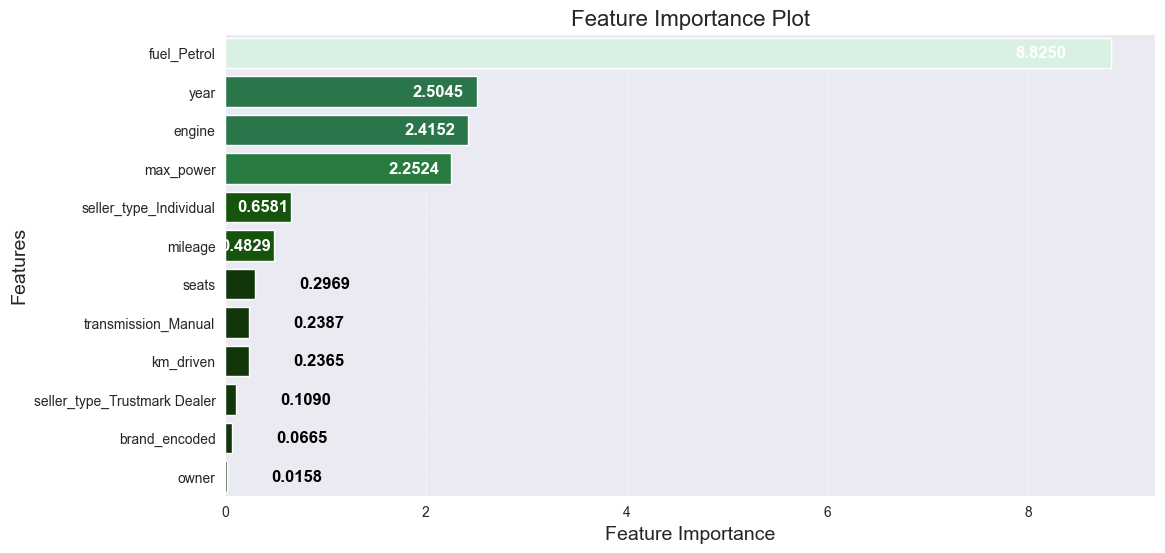

In [345]:
finalmodel.plot_feature_importance(transformed_feature_names)

## Inference 

In [272]:

val = np.array(['audi',2010,51000,'Diesel','Individual','Automatic',1,20,800,40,4])
# Convert input to a DataFrame
columns = ['brand', 'year', 'km_driven', 'fuel', 'seller_type',
           'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']
val = pd.DataFrame([val], columns=columns)

val['brand_encoded'] = val['brand'].map(brand_means)
if val['brand_encoded'].isnull().any():
    val['brand_encoded'] = val['brand_encoded'].fillna(brand_means.mean())

val = val.drop(columns=['brand'])
    
numeric_cols = ['year', 'km_driven', 'owner', 'mileage', 'engine', 'max_power', 'seats', 'brand_encoded']
val[numeric_cols] = val[numeric_cols].apply(pd.to_numeric)

val_transformed = preprocessor.transform(val)

val_tensor = torch.tensor(val_transformed, dtype=torch.float32, device=finalmodel.device)
predicted_price = torch.expm1(finalmodel._predict(val_tensor))

print(f"Predicted Price: {predicted_price.item():,.2f}")

Predicted Price: 11,000.00


In [275]:
joblib.dump(brand_means, 'brand_means.pkl')

['brand_means.pkl']

In [277]:
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [196]:
joblib.dump(finalmodel, 'TorchRegression.pkl')

['TorchRegression.pkl']

In [255]:
Xtrain

,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand_encoded
6469,2015,64800,Diesel,Individual,Manual,1,15.10,2179.0,140.0,7.0,618594.786207
121,2010,162000,Petrol,Individual,Manual,2,19.00,998.0,66.1,5.0,397330.078803
3666,2016,100000,Diesel,Individual,Manual,1,25.32,1198.0,77.0,6.0,618594.786207
418,2005,150000,Petrol,Individual,Manual,2,19.70,796.0,46.3,5.0,397330.078803
3221,2011,80000,Diesel,Individual,Manual,1,17.00,1405.0,71.0,5.0,343239.822355
...,...,...,...,...,...,...,...,...,...,...,...
3772,2019,21000,Petrol,Individual,Manual,1,25.17,799.0,53.3,5.0,448503.024540
5191,2013,69000,Diesel,Individual,Manual,2,22.90,1248.0,74.0,5.0,397330.078803
5226,2013,57000,Diesel,Individual,Manual,1,22.90,1248.0,74.0,5.0,397330.078803
5390,2015,25000,Petrol,Individual,Manual,1,20.40,1197.0,81.8,5.0,397330.078803


In [281]:
df

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,1,22.69,1995.0,190.00,5.0
1,BMW,2012,900000,155000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,4.0
2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,1,19.59,1995.0,187.74,5.0
3,BMW,2009,1100000,60000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,5.0
4,BMW,2012,1100000,80000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6658,Tata,2018,459999,35000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0
6659,Tata,2017,400000,53000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0
6660,Tata,2015,450000,40000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0
6661,Tata,2015,500000,20000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0


## Feature Importance

In [292]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression

In [322]:
## statistical test (F test)

selector = SelectKBest(score_func=f_regression, k=10)  # select top 10 features
X_new = selector.fit_transform(Xtrain_transformed, np.log1p(ytrain))
selected_stats = selector.get_support(indices=True)
print("Selected feature indices:", selected_stats)

Selected feature indices: [ 0  1  3  4  5  6  7  9 10 11]


In [314]:
Xtrain

,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand_encoded
6469,2015,64800,Diesel,Individual,Manual,1,15.10,2179.0,140.0,7.0,618594.786207
121,2010,162000,Petrol,Individual,Manual,2,19.00,998.0,66.1,5.0,397330.078803
3666,2016,100000,Diesel,Individual,Manual,1,25.32,1198.0,77.0,6.0,618594.786207
418,2005,150000,Petrol,Individual,Manual,2,19.70,796.0,46.3,5.0,397330.078803
3221,2011,80000,Diesel,Individual,Manual,1,17.00,1405.0,71.0,5.0,343239.822355
...,...,...,...,...,...,...,...,...,...,...,...
3772,2019,21000,Petrol,Individual,Manual,1,25.17,799.0,53.3,5.0,448503.024540
5191,2013,69000,Diesel,Individual,Manual,2,22.90,1248.0,74.0,5.0,397330.078803
5226,2013,57000,Diesel,Individual,Manual,1,22.90,1248.0,74.0,5.0,397330.078803
5390,2015,25000,Petrol,Individual,Manual,1,20.40,1197.0,81.8,5.0,397330.078803


In [305]:
Xtrain_transformed

array([[ 0.    ,  1.    ,  0.    , ...,  1.5474, -0.6824,  0.2682],
       [ 1.    ,  1.    ,  0.    , ..., -0.4557,  0.6783, -0.371 ],
       [ 0.    ,  1.    ,  0.    , ...,  0.5459, -0.6824,  0.2682],
       ...,
       [ 0.    ,  1.    ,  0.    , ..., -0.4557, -0.6824, -0.371 ],
       [ 1.    ,  1.    ,  0.    , ..., -0.4557, -0.6824, -0.371 ],
       [ 0.    ,  1.    ,  0.    , ...,  3.5505, -0.6824,  0.2682]],
      shape=(5330, 12))

In [319]:
## Embedded method 
lasso = Lasso(alpha=0.1)  # adjust alpha as needed
lasso.fit(Xtrain_transformed, np.log1p(ytrain))
# Coefficients that are exactly 0 indicate that the feature is not important.
selected_indices = np.where(lasso.coef_ != 0)[0]
print("Selected feature indices:", selected_indices)

Selected feature indices: [ 7  9 11]


In [316]:
lasso.coef_

array([-0.    , -0.    ,  0.    , -0.    , -0.    ,  0.    ,  0.    ,
        0.4111, -0.    ,  0.0641, -0.    ,  0.2115])

In [348]:
finalmodel.fit(Xtrain_transformed[selected_stats], ytrain)

(5330,)
torch.Size([10, 13])
0 --> train_loss: 13.923 | train_accuracy: -29.0783 | val_loss: 57.9366 | val_accuracy: -inf
early stopping
1 --> train_loss: 14.364 | train_accuracy: -29.4894 | val_loss: 1.5623 | val_accuracy: -inf
2 --> train_loss: 14.306 | train_accuracy: -28.6208 | val_loss: 2.4905 | val_accuracy: -inf
3 --> train_loss: 13.970 | train_accuracy: -29.7874 | val_loss: 30.9077 | val_accuracy: -inf
4 --> train_loss: 13.993 | train_accuracy: -28.8251 | val_loss: 2.4684 | val_accuracy: -inf
early stopping
5 --> train_loss: 14.628 | train_accuracy: -29.4558 | val_loss: 0.2726 | val_accuracy: -inf
early stopping
6 --> train_loss: 15.074 | train_accuracy: -30.6749 | val_loss: 0.0006 | val_accuracy: -inf
7 --> train_loss: 14.987 | train_accuracy: -29.9970 | val_loss: 0.2502 | val_accuracy: -inf
early stopping
8 --> train_loss: 15.363 | train_accuracy: -31.7296 | val_loss: 0.0000 | val_accuracy: -inf
9 --> train_loss: 15.211 | train_accuracy: -30.9835 | val_loss: 2.3818 | val_accu